In [75]:
# WFDB IMPORTS
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath

import wfdb
import wfdb.processing as proc


# PYHRV IMPORTS
import biosppy
import pyhrv
import pyhrv.time_domain as td

# MATH
import math

# SKLEARN
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, zero_one_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# STATS
import pandas as pd

# CONSTANTS
seed = 1234

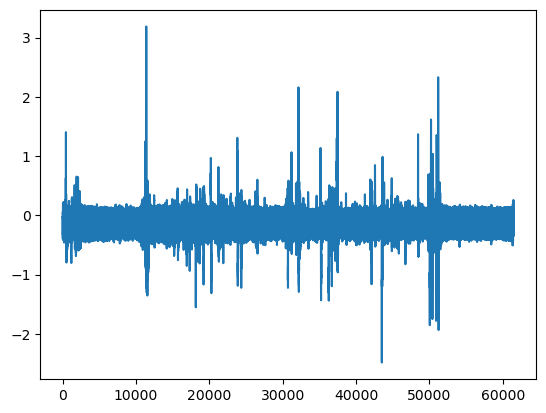

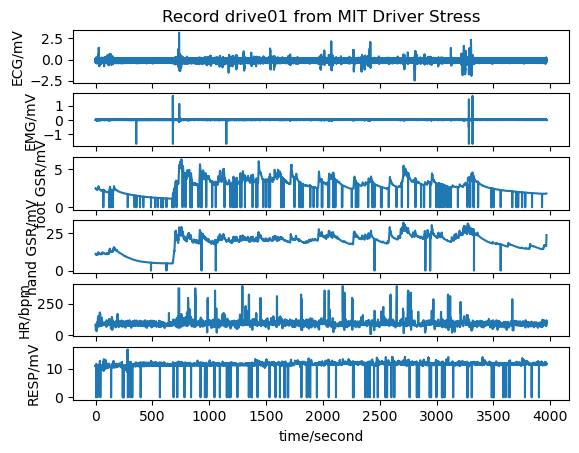

{'record_name': 'drive01',
 'n_sig': 6,
 'fs': 15.5,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 61499,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'RESP'],
 'p_signal': array([[-3.0000e-02, -7.2000e-03,  2.5040e+00,  1.1146e+01,  8.4000e+01,
          1.0948e+01],
        [-2.6000e-02, -3.3000e-03,  2.5120e+00,  1.1136e+01,  8.4000e+01,
          1.0958e+01],
        [-1.6000e-02,  1.9000e-03,  2.5140e+00,  1.1127e+01,  8.4000e+01,
          1.0982e+01],
        ...,
        [ 6.7000e-02, -4.9000e-03,  1.7850e+00,  2.3291e+01,  9.4000e+01,
          1.1642e+01],
        [ 5.4000e-02,  1.5000e-03,  1.7850e+00,  2.3502e+01,  9.4000e+01,
          1.1750e+01],
        [ 4.9000e-02, -6.4000e-03,  1.7860e+00,  2.3738e+01,  9.4000e+01,
          1.1828e+01]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['drive01.dat',
  'drive01.dat',
  'drive01.dat',
  'drive01.dat',
  'driv

In [2]:
# Demo 1 - Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
#record = wfdb.rdrecord('sample-data/a103l') 
record = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive01')
sig, fields = wfdb.rdsamp('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive01', channels=[0])

ann = wfdb.rdann('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive01', 'dat', sampto=61499)
plt.plot([i for i in range(61499)], sig[:,0])

wfdb.plot_wfdb(record=record, title='Record drive01 from MIT Driver Stress')
display(record.__dict__)

# 0: Data Splits and Labeling

For each driver data:
    1. Save the original as a csv
    2. Find the mean foot GSR
    3. Label data above mean GSR as stress, anything at or below is no stress

**Notes:
- I originally thought that the data for driver02 would have to be indexed based on driver01's last index, but now realizing I don't need to do this bc we will be collecting the HR metric of each individually and then combining those HR metrics into stress/no_stress training and testing sets. In other words, the data we are splitting in this step is not our final training/testing sets, but rather will be used to extract the training/testing sets in part 1.
- Driver 1 is already done.
- Need to think of a way to find 30s intervals for part 1.

## 0.1: Drive1

In [3]:
# Load in drive 1's data
record_1 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive01')
record_dict_1 = record_1.__dict__

# Save data as CSV
DF = pd.DataFrame(values_1)
DF.to_csv("drive01.csv")

NameError: name 'values_1' is not defined

In [3]:
# Read CSV
record_1 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive01.csv')
footGSR_vals_1 = record_1.values[:,3]
values_1 = record_1.values

# Find mean GSR
mean_footGSR_1 = np.mean(footGSR_vals_1)

print(mean_footGSR_1)

values_1 = np.array(values_1)

stress_1 = values_1[(values_1[:,3] > mean_footGSR_1),:]
no_stress_1 = values_1[(values_1[:,3] <= mean_footGSR_1),:]

print("Stress\n", stress_1)
print("No Stress \n", no_stress_1)

# Indices of stress/no_stress data points
stress_inds_1 = stress_1[:,0]
no_stress_inds_1 = no_stress_1[:,0]
print(record_1.__dict__)
print(len(stress_1[0,:]))

2.8902447519471863
Stress
 [[ 1.0860e+04  6.7000e-02 -6.8000e-03 ...  2.3213e+01  9.7000e+01
   1.1042e+01]
 [ 1.0861e+04  6.9000e-02 -4.5000e-03 ...  2.3356e+01  9.7000e+01
   1.1040e+01]
 [ 1.0862e+04  2.2000e-02 -4.0000e-03 ...  2.3494e+01  9.7000e+01
   1.1040e+01]
 ...
 [ 5.2705e+04  1.4400e-01  3.0000e-03 ...  2.1420e+01  8.3000e+01
   1.1716e+01]
 [ 5.2706e+04  9.3000e-02 -7.5000e-03 ...  2.1412e+01  8.3000e+01
   1.1704e+01]
 [ 5.2707e+04  7.4000e-02 -4.7000e-03 ...  2.1410e+01  8.3000e+01
   1.1696e+01]]
No Stress 
 [[ 0.0000e+00 -3.0000e-02 -7.2000e-03 ...  1.1146e+01  8.4000e+01
   1.0948e+01]
 [ 1.0000e+00 -2.6000e-02 -3.3000e-03 ...  1.1136e+01  8.4000e+01
   1.0958e+01]
 [ 2.0000e+00 -1.6000e-02  1.9000e-03 ...  1.1127e+01  8.4000e+01
   1.0982e+01]
 ...
 [ 6.1496e+04  6.7000e-02 -4.9000e-03 ...  2.3291e+01  9.4000e+01
   1.1642e+01]
 [ 6.1497e+04  5.4000e-02  1.5000e-03 ...  2.3502e+01  9.4000e+01
   1.1750e+01]
 [ 6.1498e+04  4.9000e-02 -6.4000e-03 ...  2.3738e+01  9.40

In [25]:
# Save stress/no stress as csv
stressDF = pd.DataFrame(stress)
stressDF.to_csv("stress01.csv")

no_stressDF = pd.DataFrame(no_stress)
no_stressDF.to_csv("no_stress01.csv")

## 0.2: Drive2

In [10]:
# Load in drive 2's data
record_2 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive02')
record_dict_2 = record_2.__dict__
values_2 = record_dict_2['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_2)
DF.to_csv("drive02.csv")

In [4]:
# Read CSV
record_2 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive02.csv')
footGSR_vals_2 = record_2.values[:,3]
values_2 = record_2.values

# Find mean GSR
mean_footGSR_2 = np.mean(footGSR_vals_2)

# Visualize
# print(signals_2)
# print(values_2)
print("Mean Foot GSR: ", mean_footGSR_2)

values_2 = np.array(values_2)

stress_2 = values_2[(values_2[:,3] > mean_footGSR_2),:]
no_stress_2 = values_2[(values_2[:,3] <= mean_footGSR_2),:]

print("Stress\n", stress_2)
print("No Stress \n", no_stress_2)

# Indices of stress/no_stress data points
stress_inds_2 = stress_2[:,0]
no_stress_inds_2 = no_stress_2[:,0]

# print(record_2.__dict__['sig_name'])
# print(len(stress_2[0,:]))

Mean Foot GSR:  71.11477537306206
Stress
 [[ 0.00000000e+00 -6.03000000e-01  1.80200000e+00  7.49925007e+01
   0.00000000e+00  1.15740000e+01]
 [ 1.00000000e+00 -4.09000000e-01  1.80200000e+00  7.49925007e+01
   0.00000000e+00  1.14720000e+01]
 [ 2.00000000e+00 -4.05000000e-01  1.80200000e+00  7.79922008e+01
   0.00000000e+00  1.13880000e+01]
 ...
 [ 7.80530000e+04  6.07000000e-01  1.17900000e+00  9.99900010e+01
   1.87500000e+01  1.39320000e+01]
 [ 7.80540000e+04 -1.84000000e-01  1.18100000e+00  9.99900010e+01
   1.86800000e+01  1.38980000e+01]
 [ 7.80550000e+04  2.00000000e-02  1.18100000e+00  9.99900010e+01
   1.86100000e+01  1.38680000e+01]]
No Stress 
 [[ 2.30000000e+01  1.80000000e-02  1.72800000e+00  6.49935007e+01
   0.00000000e+00  1.27380000e+01]
 [ 2.40000000e+01  4.40000000e-02  1.72800000e+00  6.49935007e+01
   0.00000000e+00  1.27780000e+01]
 [ 2.50000000e+01 -3.17000000e-01  1.72600000e+00  6.49935007e+01
   0.00000000e+00  1.28080000e+01]
 ...
 [ 7.79930000e+04  3.96000

## 0.3: Drive3

*Note: This trial contains significant missing data and lost a signal, and as such will not be used.

In [13]:
# Load in drive 3's data
record_3 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive03')
record_dict_3 = record_3.__dict__
values_3 = record_dict_3['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_3)
DF.to_csv("drive03.csv")

In [38]:
# Read CSV
record_3 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive03.csv')
footGSR_vals_3 = record_3.values[:,3]
values_3 = record_3.values

# Find mean GSR
mean_footGSR_3 = np.mean(footGSR_vals_3)

# Visualize
# print(signals_3)
# print(values_3)
print("Mean Foot GSR: ", mean_footGSR_3)

values_3 = np.array(values_3)

stress_3 = values_3[(values_3[:,3] > mean_footGSR_3),:]
no_stress_3 = values_3[(values_3[:,3] <= mean_footGSR_3),:]

print("Stress\n", stress_3)
print("No Stress \n", no_stress_3)

# Indices of stress/no_stress data points
stress_inds_3 = stress_3[:,0]
no_stress_inds_3 = no_stress_3[:,0]

print(record_3.__dict__)

Mean Foot GSR:  3.3574362963693196
Stress
 [[ 4.32730e+04 -8.00000e-03  1.25000e+00  3.35900e+00 -9.85300e+00]
 [ 4.32740e+04 -4.00000e-03  1.25000e+00  3.36300e+00 -9.93800e+00]
 [ 4.32750e+04  3.60000e-02  1.25300e+00  3.36800e+00 -1.01090e+01]
 ...
 [ 1.48255e+05 -3.40000e-02  1.67600e+00  3.35900e+00 -8.47300e+00]
 [ 1.48256e+05 -3.30000e-02  1.67600e+00  3.35900e+00 -8.43700e+00]
 [ 1.48257e+05 -3.10000e-02  1.67600e+00  3.35900e+00 -8.44900e+00]]
No Stress 
 [[ 0.00000e+00  2.20000e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.00000e+00  3.00000e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.00000e+00  3.40000e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 ...
 [ 1.72444e+05 -3.00000e-02  1.14100e+00  2.58300e+00 -9.92600e+00]
 [ 1.72445e+05 -8.00000e-03  1.14100e+00  2.58300e+00 -9.85300e+00]
 [ 1.72446e+05 -1.00000e-02  1.14100e+00  2.58000e+00 -9.80400e+00]]
{'_is_copy': None, '_mgr': BlockManager
Items: Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')
Axis 1: Rang

## 0.4: Drive4

In [15]:
# Load in drive 4's data
record_4 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive04')
record_dict_4 = record_4.__dict__
values_4 = record_dict_4['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_4)
DF.to_csv("drive04.csv")

In [5]:
# Read CSV
record_4 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive04.csv')
footGSR_vals_4 = record_4.values[:,3]
values_4 = record_4.values

# Find mean GSR
mean_footGSR_4 = np.mean(footGSR_vals_4)

# Visualize
# print(signals_4)
# print(values_4)
print("Mean Foot GSR: ", mean_footGSR_4)

values_4 = np.array(values_4)

stress_4 = values_4[(values_4[:,3] > mean_footGSR_4),:]
no_stress_4 = values_4[(values_4[:,3] <= mean_footGSR_4),:]

print("Stress\n", stress_4)
print("No Stress \n", no_stress_4)

# Indices of stress/no_stress data points
stress_inds_4 = stress_4[:,0]
no_stress_inds_4 = no_stress_4[:,0]

print(record.__dict__['sig_name'])
print(len(stress_4[0,:]))

Mean Foot GSR:  9.942311396952771
Stress
 [[ 1.4618e+04  9.0000e-02  2.2932e+01 ...  7.9000e+01  1.7480e+01
   3.1830e+01]
 [ 1.4619e+04  7.5000e-02  2.3047e+01 ...  7.9000e+01  1.7460e+01
   3.1830e+01]
 [ 1.4620e+04  1.0600e-01  2.3185e+01 ...  7.9000e+01  1.7450e+01
   3.1860e+01]
 ...
 [ 7.6263e+04 -1.7700e-01  1.7248e+01 ...  9.7000e+01  1.8310e+01
   3.2660e+01]
 [ 7.6264e+04 -1.8200e-01  1.7243e+01 ...  9.7000e+01  1.8300e+01
   3.2660e+01]
 [ 7.6265e+04 -1.3900e-01  1.7233e+01 ...  9.7000e+01  1.8300e+01
   3.2680e+01]]
No Stress 
 [[ 0.0000e+00 -7.1000e-02  1.9302e+01 ...  5.3000e+01  1.3190e+01
   3.5530e+01]
 [ 1.0000e+00 -7.6000e-02  1.9319e+01 ...  5.3000e+01  1.3200e+01
   3.5540e+01]
 [ 2.0000e+00 -3.0000e-03  1.9341e+01 ...  5.3000e+01  1.3200e+01
   3.5550e+01]
 ...
 [ 7.2532e+04 -8.1000e-02  1.6192e+01 ...  5.3000e+01  1.6240e+01
   3.5020e+01]
 [ 7.2533e+04 -9.3000e-02  1.6184e+01 ...  5.3000e+01  1.6240e+01
   3.4910e+01]
 [ 7.2534e+04 -4.0000e-02  1.6179e+01 ...  5

## 0.5: Drive5

In [4]:
# Load in drive 5's data
record_5 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive05')
record_dict_5 = record_5.__dict__
values_5 = record_dict_5['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_5)
DF.to_csv("drive05.csv")

In [6]:
# Read CSV
record_5 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive05.csv')
footGSR_vals_5 = record_5.values[:,3]
values_5 = record_5.values

# Find mean GSR
mean_footGSR_5 = np.mean(footGSR_vals_5)

# Visualize
# print(signals_5)
# print(values_5)
print("Mean Foot GSR: ", mean_footGSR_5)

values_5 = np.array(values_5)

stress_5 = values_5[(values_5[:,3] > mean_footGSR_5),:]
no_stress_5 = values_5[(values_5[:,3] <= mean_footGSR_5),:]

print("Stress\n", stress_5)
print("No Stress \n", no_stress_5)

# Indices of stress/no_stress data points
stress_inds_5 = stress_5[:,0]
no_stress_inds_5 = no_stress_5[:,0]

print(record.__dict__['sig_name'])
print(len(stress_2[0,:]))

Mean Foot GSR:  4.825778095371776
Stress
 [[ 0.0000e+00 -5.4000e-02  3.7300e-01 ...  8.9000e+01  1.2480e+01
   3.3670e+01]
 [ 1.0000e+00 -1.0000e-03  2.4900e-01 ...  8.9000e+01  1.2480e+01
   3.3290e+01]
 [ 2.0000e+00 -1.0000e-01  3.5200e-01 ...  8.9000e+01  1.2480e+01
   3.2940e+01]
 ...
 [ 6.3584e+04 -3.0000e-03  9.3200e-01 ...  8.5000e+01  1.9850e+01
   3.6850e+01]
 [ 6.3585e+04 -8.1000e-02  6.2200e-01 ...  8.5000e+01  1.9850e+01
   3.6630e+01]
 [ 6.3586e+04  3.2400e-01  4.3500e-01 ...  8.5000e+01  1.9850e+01
   3.6350e+01]]
No Stress 
 [[ 4.6800e+02  2.7400e-01  2.2800e-01 ...  7.3000e+01  1.2440e+01
   2.4980e+01]
 [ 4.6900e+02  2.5600e-01  2.0700e-01 ...  7.3000e+01  1.2490e+01
   2.4820e+01]
 [ 4.7000e+02  5.0000e-03  1.6600e-01 ...  7.3000e+01  1.2540e+01
   2.4580e+01]
 ...
 [ 7.8364e+04  1.6400e-01  6.3400e+00 ...  7.7000e+01  1.8480e+01
   3.0600e+01]
 [ 7.8365e+04  1.5700e-01  4.5170e+00 ...  7.7000e+01  1.8500e+01
   3.1010e+01]
 [ 7.8366e+04 -5.4000e-02  5.6560e+00 ...  7

## 0.6: Drive 6

In [6]:
# Load in drive 6's data
record_6 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive06')
record_dict_6 = record_6.__dict__
values_6 = record_dict_6['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_6)
DF.to_csv("drive06.csv")

In [7]:
# Read CSV
record_6 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive06.csv')
footGSR_vals_6 = record_6.values[:,3]
values_6 = record_6.values

# Find mean GSR
mean_footGSR_6 = np.mean(footGSR_vals_6)

# Visualize
# print(signals_6)
# print(values_6)
print("Mean Foot GSR: ", mean_footGSR_6)

values_6 = np.array(values_6)

stress_6 = values_6[(values_6[:,3] > mean_footGSR_6),:]
no_stress_6 = values_6[(values_6[:,3] <= mean_footGSR_6),:]

print("Stress\n", stress_6)
print("No Stress \n", no_stress_6)

# Indices of stress/no_stress data points
stress_inds_6 = stress_6[:,0]
no_stress_inds_6 = no_stress_6[:,0]

print(record.__dict__['sig_name'])
print(len(stress_6[0,:]))

Mean Foot GSR:  8.621147065479281
Stress
 [[ 0.0000e+00 -8.3000e-02  1.2400e-01 ...  9.0000e+01  1.2360e+01
   3.9980e+01]
 [ 1.0000e+00 -7.9000e-02  1.4500e-01 ...  9.0000e+01  1.2360e+01
   4.0000e+01]
 [ 2.0000e+00 -8.6000e-02  1.6600e-01 ...  9.0000e+01  1.2360e+01
   3.9970e+01]
 ...
 [ 5.2355e+04 -6.9000e-02  3.2320e+00 ...  9.4000e+01  1.0410e+01
   2.8680e+01]
 [ 5.2356e+04  1.9200e-01  1.4710e+00 ...  9.4000e+01  1.0400e+01
   2.8930e+01]
 [ 5.2357e+04 -2.9000e-02  1.3470e+00 ...  9.4000e+01  1.0400e+01
   2.9110e+01]]
No Stress 
 [[ 3.4300e+02 -8.1000e-02  6.2200e-01 ...  8.0000e+01  1.2280e+01
   3.5870e+01]
 [ 3.4400e+02 -3.6000e-02  7.4600e-01 ...  8.0000e+01  1.2280e+01
   3.5640e+01]
 [ 3.4500e+02 -9.6000e-02  3.7300e-01 ...  8.0000e+01  1.2290e+01
   3.5450e+01]
 ...
 [ 7.5120e+04  2.4300e-01  4.3500e-01 ...  8.2000e+01  1.1340e+01
   3.3720e+01]
 [ 7.5121e+04 -3.3000e-02  3.9400e-01 ...  8.2000e+01  1.1340e+01
   3.3700e+01]
 [ 7.5122e+04 -6.1000e-02  4.1400e-01 ...  7

## 0.7: Drive7

In [8]:
# Load in drive 7's data
record_7 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive07')
record_dict_7 = record_7.__dict__
values_7 = record_dict_7['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_7)
DF.to_csv("drive07.csv")

In [8]:
# Read CSV
record_7 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive07.csv')
footGSR_vals_7 = record_7.values[:,3]
values_7 = record_7.values

# Find mean GSR
mean_footGSR_7 = np.mean(footGSR_vals_7)

# Visualize
# print(signals_7)
# print(values_7)
print("Mean Foot GSR: ", mean_footGSR_7)

values_7 = np.array(values_7)

stress_7 = values_7[(values_7[:,3] > mean_footGSR_7),:]
no_stress_7 = values_7[(values_7[:,3] <= mean_footGSR_7),:]

print("Stress\n", stress_7)
print("No Stress \n", no_stress_7)

# Indices of stress/no_stress data points
stress_inds_7 = stress_7[:,0]
no_stress_inds_7 = no_stress_7[:,0]

print(record.__dict__['sig_name'])
print(len(stress_7[0,:]))

Mean Foot GSR:  11.51735764537493
Stress
 [[ 1.59940e+04  9.50000e-02  4.45500e-01 ...  7.20000e+01  1.58800e+01
   3.95500e+01]
 [ 1.59950e+04 -1.36000e-01  4.09250e-01 ...  7.20000e+01  1.58100e+01
   3.97100e+01]
 [ 1.59960e+04 -6.80000e-02  3.83250e-01 ...  7.20000e+01  1.57900e+01
   4.00000e+01]
 ...
 [ 8.24390e+04  3.56000e+00  9.16750e-01 ...  7.50000e+01  1.28000e+01
   3.74100e+01]
 [ 8.24400e+04  3.79400e+00  1.33125e+00 ...  7.50000e+01  1.28000e+01
   3.72600e+01]
 [ 8.24410e+04  4.12900e+00  1.10850e+00 ...  7.50000e+01  1.28000e+01
   3.72300e+01]]
No Stress 
 [[ 0.0000e+00  1.6000e-02  3.6250e-02 ...  8.8000e+01  1.0850e+01
   4.3470e+01]
 [ 1.0000e+00 -9.8000e-02  5.1750e-02 ...  8.8000e+01  1.0850e+01
   4.3020e+01]
 [ 2.0000e+00  2.7300e-01  7.7750e-02 ...  8.8000e+01  1.0850e+01
   4.2560e+01]
 ...
 [ 8.0052e+04  2.5000e-02  7.2500e-02 ...  6.4000e+01  1.2050e+01
   3.7730e+01]
 [ 8.0053e+04  1.5700e-01  6.2250e-02 ...  6.4000e+01  1.2050e+01
   3.8040e+01]
 [ 8.005

## 0.8: Drive8

In [10]:
# Load in drive 8's data
record_8 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive08')
record_dict_8 = record_8.__dict__
values_8 = record_dict_8['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_8)
DF.to_csv("drive08.csv")

In [9]:
# Read CSV
record_8 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive08.csv')
footGSR_vals_8 = record_8.values[:,3]
values_8 = record_8.values

# Find mean GSR
mean_footGSR_8 = np.mean(footGSR_vals_8)

# Visualize
# print(signals_8)
# print(values_8)
print("Mean Foot GSR: ", mean_footGSR_8)

values_8 = np.array(values_8)

stress_8 = values_8[(values_8[:,3] > mean_footGSR_8),:]
no_stress_8 = values_8[(values_8[:,3] <= mean_footGSR_8),:]

print("Stress\n", stress_8)
print("No Stress \n", no_stress_8)

# Indices of stress/no_stress data points
stress_inds_8 = stress_8[:,0]
no_stress_inds_8 = no_stress_8[:,0]

print(record.__dict__['sig_name'])
print(len(stress_8[0,:]))

Mean Foot GSR:  5.257273225708194
Stress
 [[ 0.00000e+00  1.17000e-01  3.54750e-01 ...  5.90000e+01  1.66300e+01
   4.87700e+01]
 [ 1.00000e+00 -1.39000e-01  3.05625e-01 ...  5.60000e+01  1.66000e+01
   4.87000e+01]
 [ 2.00000e+00 -1.42000e-01  3.72875e-01 ...  5.60000e+01  1.66300e+01
   4.85800e+01]
 ...
 [ 6.15380e+04 -1.58000e-01  3.60000e-01 ...  7.60000e+01  9.65000e+00
   5.21300e+01]
 [ 6.15390e+04  2.30000e-01  2.92625e-01 ...  7.60000e+01  9.63000e+00
   5.21500e+01]
 [ 6.15400e+04 -4.60000e-02  3.62625e-01 ...  7.60000e+01  9.61000e+00
   5.21700e+01]]
No Stress 
 [[ 1.20300e+03 -7.50000e-02  1.16500e-01 ...  6.40000e+01  1.36600e+01
   5.01600e+01]
 [ 1.20400e+03 -4.70000e-02  2.27875e-01 ...  6.40000e+01  1.36600e+01
   5.01200e+01]
 [ 1.20500e+03 -1.04000e-01  3.57375e-01 ...  6.40000e+01  1.36700e+01
   5.00000e+01]
 ...
 [ 7.55060e+04 -1.00000e+01  0.00000e+00 ...  0.00000e+00  1.15300e+01
   0.00000e+00]
 [ 7.55070e+04 -1.00000e+01  0.00000e+00 ...  0.00000e+00  1.1490

## 0.9: Drive9

In [12]:
# Load in drive 9's data
record_9 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive09')
record_dict_9 = record_9.__dict__
values_9 = record_dict_9['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_9)
DF.to_csv("drive09.csv")

In [10]:
# Read CSV
record_9 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive09.csv')
footGSR_vals_9 = record_9.values[:,3]
values_9 = record_9.values

# Find mean GSR
mean_footGSR_9 = np.mean(footGSR_vals_9)

# Visualize
# print(signals_9)
# print(values_9)
print("Mean Foot GSR: ", mean_footGSR_9)

values_9 = np.array(values_9)

stress_9 = values_9[(values_9[:,3] > mean_footGSR_9),:]
no_stress_9 = values_9[(values_9[:,3] <= mean_footGSR_9),:]

print("Stress\n", stress_9)
print("No Stress \n", no_stress_9)

# Indices of stress/no_stress data points
stress_inds_9 = stress_9[:,0]
no_stress_inds_9 = no_stress_9[:,0]

print(record.__dict__['sig_name'])
print(len(stress_9[0,:]))

Mean Foot GSR:  4.472794544240806
Stress
 [[ 1.5818e+04  8.7000e-02  3.4190e+00 ...  8.3000e+01  1.0620e+01
   5.0980e+01]
 [ 1.6237e+04  2.1400e-01  3.1100e-01 ...  7.5000e+01  1.0650e+01
   4.1110e+01]
 [ 1.6238e+04  3.3900e-01  3.7300e-01 ...  7.5000e+01  1.0610e+01
   4.1380e+01]
 ...
 [ 6.5357e+04 -5.8000e-02  3.7300e-01 ...  9.0000e+01  1.1330e+01
   3.6590e+01]
 [ 6.5358e+04 -7.9000e-02  3.7300e-01 ...  9.0000e+01  1.1330e+01
   3.6570e+01]
 [ 6.5359e+04 -1.0400e-01  3.7300e-01 ...  9.0000e+01  1.1330e+01
   3.6440e+01]]
No Stress 
 [[ 0.0000e+00  7.1000e-02  2.0700e-01 ...  7.8000e+01  9.6500e+00
   4.5400e+01]
 [ 1.0000e+00  4.5000e-02  2.2800e-01 ...  7.8000e+01  9.6300e+00
   4.5140e+01]
 [ 2.0000e+00  5.7000e-02  1.8600e-01 ...  7.8000e+01  9.6300e+00
   4.4860e+01]
 ...
 [ 6.5909e+04 -1.0000e+01  0.0000e+00 ...  0.0000e+00  1.0510e+01
   0.0000e+00]
 [ 6.5910e+04 -1.0000e+01  0.0000e+00 ...  0.0000e+00  1.0070e+01
   0.0000e+00]
 [ 6.5911e+04 -1.0000e+01  0.0000e+00 ...  0

## 0.10: Driver10

In [14]:
# Load in drive 10's data
record_10 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive10')
record_dict_10 = record_10.__dict__
values_10 = record_dict_10['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_10)
DF.to_csv("drive10.csv")

In [11]:
# Read CSV
record_10 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive10.csv')
footGSR_vals_10 = record_10.values[:,3]
values_10 = record_10.values

# Find mean GSR
mean_footGSR_10 = np.mean(footGSR_vals_10)

# Visualize
# print(signals_10)
# print(values_10)
print("Mean Foot GSR: ", mean_footGSR_10)

values_10 = np.array(values_10)

stress_10 = values_10[(values_10[:,3] > mean_footGSR_10),:]
no_stress_10 = values_10[(values_10[:,3] <= mean_footGSR_10),:]

print("Stress\n", stress_10)
print("No Stress \n", no_stress_10)

# Indices of stress/no_stress data points
stress_inds_10 = stress_10[:,0]
no_stress_inds_10 = no_stress_10[:,0]

print(record.__dict__['sig_name'])
print(len(stress_10[0,:]))

Mean Foot GSR:  7.057348383426818
Stress
 [[ 1.6582e+04  4.9000e-02  1.1400e+00 ...  9.5000e+01  1.1280e+01
   4.0520e+01]
 [ 1.6583e+04 -2.0400e-01  4.3500e-01 ...  9.5000e+01  1.1280e+01
   4.0290e+01]
 [ 1.6584e+04 -1.6500e-01  1.3050e+00 ...  9.5000e+01  1.1280e+01
   4.0090e+01]
 ...
 [ 7.5589e+04  1.1300e-01  3.7710e+00 ...  7.5000e+01  1.1960e+01
   0.0000e+00]
 [ 7.5590e+04  1.0900e-01  5.8430e+00 ...  7.5000e+01  1.1960e+01
   0.0000e+00]
 [ 7.5591e+04  1.7500e-01  5.4900e+00 ...  7.5000e+01  1.1980e+01
   0.0000e+00]]
No Stress 
 [[ 0.0000e+00  1.4000e-01  2.4900e-01 ...  7.8000e+01  1.1380e+01
   3.5500e+01]
 [ 1.0000e+00 -3.7000e-02  2.2800e-01 ...  7.8000e+01  1.1380e+01
   3.5510e+01]
 [ 2.0000e+00 -4.3000e-02  2.2800e-01 ...  7.8000e+01  1.1380e+01
   3.5490e+01]
 ...
 [ 7.5149e+04 -2.5000e-02  5.1380e+00 ...  8.6000e+01  1.2280e+01
   0.0000e+00]
 [ 7.5150e+04  1.9000e-02  5.0350e+00 ...  8.4000e+01  1.2280e+01
   0.0000e+00]
 [ 7.5151e+04  1.3000e-01  3.9570e+00 ...  8

## 0.11: Driver11

In [16]:
# Load in drive 11's data
record_11 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive11')
record_dict_11 = record_11.__dict__
values_11 = record_dict_11['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_11)
DF.to_csv("drive11.csv")

In [12]:
# Read CSV
record_11 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive11.csv')
footGSR_vals_11 = record_11.values[:,3]
values_11 = record_11.values

# Find mean GSR
mean_footGSR_11 = np.mean(footGSR_vals_11)

# Visualize
# print(signals_11)
# print(values_11)
print("Mean Foot GSR: ", mean_footGSR_11)

values_11 = np.array(values_11)

stress_11 = values_11[(values_11[:,3] > mean_footGSR_11),:]
no_stress_11 = values_11[(values_11[:,3] <= mean_footGSR_11),:]

print("Stress\n", stress_11)
print("No Stress \n", no_stress_11)

# Indices of stress/no_stress data points
stress_inds_11 = stress_11[:,0]
no_stress_inds_11 = no_stress_11[:,0]

print(record.__dict__['sig_name'])
print(len(stress_11[0,:]))

Mean Foot GSR:  5.027651079660546
Stress
 [[ 0.00000e+00 -5.50000e-02  2.92625e-01 ...  7.00000e+01  1.15900e+01
   5.10200e+01]
 [ 1.00000e+00  7.00000e-03  3.21125e-01 ...  7.00000e+01  1.15700e+01
   5.10100e+01]
 [ 2.00000e+00 -6.80000e-02  3.49625e-01 ...  7.00000e+01  1.15700e+01
   5.09900e+01]
 ...
 [ 6.14520e+04 -1.47000e-01  1.99375e-01 ...  7.00000e+01  1.11200e+01
   5.17600e+01]
 [ 6.14530e+04 -1.36000e-01  3.57375e-01 ...  7.00000e+01  1.12000e+01
   5.16700e+01]
 [ 6.14540e+04 -8.40000e-02  1.70875e-01 ...  7.00000e+01  1.12100e+01
   5.16200e+01]]
No Stress 
 [[ 2.489000e+03 -1.440000e-01  2.252500e-01 ...  5.800000e+01
   1.072000e+01  4.909000e+01]
 [ 2.490000e+03 -1.440000e-01  2.252500e-01 ...  5.800000e+01
   1.072000e+01  4.911000e+01]
 [ 2.491000e+03 -1.150000e-01  2.512500e-01 ...  5.800000e+01
   1.072000e+01  4.927000e+01]
 ...
 [ 7.553000e+04  3.000000e-03  2.071875e+00 ...  8.400000e+01
   1.115000e+01  1.876000e+01]
 [ 7.553100e+04  1.490000e-01  3.910625e+

## 0.12: Driver12

In [18]:
# Load in drive 12's data
record_12 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive12')
record_dict_12 = record_12.__dict__
values_12 = record_dict_12['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_12)
DF.to_csv("drive12.csv")

In [13]:
# Read CSV
record_12 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive12.csv')
footGSR_vals_12 = record_12.values[:,3]
values_12 = record_12.values

# Find mean GSR
mean_footGSR_12 = np.mean(footGSR_vals_12)

# Visualize
# print(signals_12)
# print(values_12)
print("Mean Foot GSR: ", mean_footGSR_12)

values_12 = np.array(values_12)

stress_12 = values_12[(values_12[:,3] > mean_footGSR_12),:]
no_stress_12 = values_12[(values_12[:,3] <= mean_footGSR_12),:]

print("Stress\n", stress_12)
print("No Stress \n", no_stress_12)

# Indices of stress/no_stress data points
stress_inds_12 = stress_12[:,0]
no_stress_inds_12 = no_stress_12[:,0]

print(record.__dict__['sig_name'])
print(len(stress_12[0,:]))

Mean Foot GSR:  4.509007507410331
Stress
 [[ 0.00000e+00 -5.90000e-02  2.53750e-01 ...  8.90000e+01  9.02000e+00
   4.51800e+01]
 [ 1.00000e+00 -1.32000e-01  1.65750e-01 ...  8.90000e+01  9.02000e+00
   4.51700e+01]
 [ 2.00000e+00 -1.67000e-01  2.64125e-01 ...  8.90000e+01  9.02000e+00
   4.51900e+01]
 ...
 [ 4.23460e+04 -5.70000e-02  2.97875e-01 ...  9.10000e+01  8.60000e+00
   4.55900e+01]
 [ 4.23470e+04 -1.93000e-01  1.19125e-01 ...  9.10000e+01  8.56000e+00
   4.50500e+01]
 [ 4.39110e+04 -1.14000e-01  1.94250e-01 ...  9.30000e+01  8.45000e+00
   4.45300e+01]]
No Stress 
 [[ 7.71400e+03 -1.10000e-01  4.13750e-02 ...  8.10000e+01  1.03700e+01
   5.02000e+01]
 [ 7.71500e+03 -1.36000e-01  2.22750e-01 ...  8.00000e+01  1.03700e+01
   5.02200e+01]
 [ 7.71600e+03 -6.80000e-02  1.99375e-01 ...  8.00000e+01  1.03700e+01
   5.02300e+01]
 ...
 [ 7.72540e+04 -1.23000e-01  2.33125e-01 ...  8.60000e+01  1.07900e+01
   4.66000e+01]
 [ 7.72550e+04 -1.17000e-01  3.18500e-01 ...  8.60000e+01  1.0790

## 0.13: Driver13

In [20]:
# Load in drive 13's data
record_13 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive13')
record_dict_13 = record_13.__dict__
values_13 = record_dict_13['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_13)
DF.to_csv("drive13.csv")

In [14]:
# Read CSV
record_13 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive13.csv')
footGSR_vals_13 = record_13.values[:,3]
values_13 = record_13.values

# Find mean GSR
mean_footGSR_13 = np.mean(footGSR_vals_13)

# Visualize
# print(signals_13)
# print(values_13)
print("Mean Foot GSR: ", mean_footGSR_13)

values_13 = np.array(values_13)

stress_13 = values_13[(values_13[:,3] > mean_footGSR_13),:]
no_stress_13 = values_13[(values_13[:,3] <= mean_footGSR_13),:]

print("Stress\n", stress_13)
print("No Stress \n", no_stress_13)

# Indices of stress/no_stress data points
stress_inds_13 = stress_13[:,0]
no_stress_inds_13 = no_stress_13[:,0]

print(record.__dict__['sig_name'])
print(len(stress_13[0,:]))

Mean Foot GSR:  11.082182332032714
Stress
 [[ 5.00000e+00  1.96000e-01  9.37500e-01 ...  7.50000e+01  9.32000e+00
   4.64900e+01]
 [ 6.00000e+00  2.81000e-01  9.24500e-01 ...  7.50000e+01  9.30000e+00
   4.65800e+01]
 [ 7.00000e+00 -6.40000e-02  9.11625e-01 ...  7.50000e+01  9.32000e+00
   4.66100e+01]
 ...
 [ 7.47840e+04 -5.60000e-02  6.47500e-01 ...  1.45000e+02  1.10600e+01
   4.62800e+01]
 [ 7.47850e+04 -1.00000e-03  6.37125e-01 ...  1.45000e+02  1.10600e+01
   4.62500e+01]
 [ 7.47860e+04 -9.90000e-02  5.90500e-01 ...  1.45000e+02  1.10600e+01
   4.62500e+01]]
No Stress 
 [[ 0.00000e+00 -2.40000e-02  9.86750e-01 ...  8.20000e+01  9.23000e+00
   4.57300e+01]
 [ 1.00000e+00 -8.10000e-02  9.99625e-01 ...  8.20000e+01  9.34000e+00
   4.55900e+01]
 [ 2.00000e+00  2.25000e-01  1.05150e+00 ...  8.20000e+01  9.34000e+00
   4.54200e+01]
 ...
 [ 7.48330e+04 -6.50000e-02  6.21500e-01 ...  9.40000e+01  1.10600e+01
   4.64600e+01]
 [ 7.48340e+04 -1.70000e-02  6.21500e-01 ...  9.40000e+01  1.106

## 0.14: Drive14

In [22]:
# Load in drive 14's data
record_14 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive14')
record_dict_14 = record_14.__dict__
values_14 = record_dict_14['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_14)
DF.to_csv("drive14.csv")

In [15]:
# Read CSV
record_14 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive14.csv')
footGSR_vals_14 = record_14.values[:,3]
values_14 = record_14.values

# Find mean GSR
mean_footGSR_14 = np.mean(footGSR_vals_14)

# Visualize
# print(signals_14)
# print(values_14)
print("Mean Foot GSR: ", mean_footGSR_14)

values_14 = np.array(values_14)

stress_14 = values_14[(values_14[:,3] > mean_footGSR_14),:]
no_stress_14 = values_14[(values_14[:,3] <= mean_footGSR_14),:]

print("Stress\n", stress_14)
print("No Stress \n", no_stress_14)

# Indices of stress/no_stress data points
stress_inds_14 = stress_14[:,0]
no_stress_inds_14 = no_stress_14[:,0]

print(record.__dict__['sig_name'])
print(len(stress_14[0,:]))

Mean Foot GSR:  11.082182332032714
Stress
 [[ 5.00000e+00  1.96000e-01  9.37500e-01 ...  2.19370e+01  9.32000e+00
   4.64900e+01]
 [ 6.00000e+00  2.81000e-01  9.24500e-01 ...  2.22360e+01  9.30000e+00
   4.65800e+01]
 [ 7.00000e+00 -6.40000e-02  9.11625e-01 ...  2.22730e+01  9.32000e+00
   4.66100e+01]
 ...
 [ 7.47840e+04 -5.60000e-02  6.47500e-01 ...  7.74000e-01  1.10600e+01
   4.62800e+01]
 [ 7.47850e+04 -1.00000e-03  6.37125e-01 ...  7.73000e-01  1.10600e+01
   4.62500e+01]
 [ 7.47860e+04 -9.90000e-02  5.90500e-01 ...  7.74000e-01  1.10600e+01
   4.62500e+01]]
No Stress 
 [[ 0.00000e+00 -2.40000e-02  9.86750e-01 ...  1.60000e+01  9.23000e+00
   4.57300e+01]
 [ 1.00000e+00 -8.10000e-02  9.99625e-01 ...  1.59630e+01  9.34000e+00
   4.55900e+01]
 [ 2.00000e+00  2.25000e-01  1.05150e+00 ...  1.59680e+01  9.34000e+00
   4.54200e+01]
 ...
 [ 7.48330e+04 -6.50000e-02  6.21500e-01 ...  7.76000e-01  1.10600e+01
   4.64600e+01]
 [ 7.48340e+04 -1.70000e-02  6.21500e-01 ...  7.76000e-01  1.106

## 0.15: Driver15

In [24]:
# Load in drive 15's data
record_15 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive15')
record_dict_15 = record_15.__dict__
values_15 = record_dict_15['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_15)
DF.to_csv("drive15.csv")

In [16]:
# Read CSV
record_15 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive15.csv')
footGSR_vals_15 = record_15.values[:,3]
values_15 = record_15.values

# Find mean GSR
mean_footGSR_15 = np.mean(footGSR_vals_15)

# Visualize
# print(signals_15)
# print(values_15)
print("Mean Foot GSR: ", mean_footGSR_15)

values_15 = np.array(values_15)

stress_15 = values_15[(values_15[:,3] > mean_footGSR_15),:]
no_stress_15 = values_15[(values_15[:,3] <= mean_footGSR_15),:]

print("Stress\n", stress_15)
print("No Stress \n", no_stress_15)

# Indices of stress/no_stress data points
stress_inds_15 = stress_15[:,0]
no_stress_inds_15 = no_stress_15[:,0]

print(record.__dict__['sig_name'])
print(len(stress_15[0,:]))

Mean Foot GSR:  6.212731889376672
Stress
 [[ 0.0000e+00 -2.5200e-01  4.3500e-01 ...  9.1000e+01  1.0170e+01
   5.1460e+01]
 [ 1.0000e+00 -2.2900e-01  2.9000e-01 ...  9.1000e+01  1.0170e+01
   5.1390e+01]
 [ 2.0000e+00  1.2400e-01  5.5900e-01 ...  9.1000e+01  1.0170e+01
   5.1310e+01]
 ...
 [ 7.2206e+04 -4.9000e-02  6.5470e+00 ...  9.6000e+01  1.0020e+01
   3.5740e+01]
 [ 7.2207e+04 -6.3000e-02  3.7910e+00 ...  9.6000e+01  1.0010e+01
   3.5710e+01]
 [ 7.2208e+04 -3.9000e-02  3.8330e+00 ...  9.6000e+01  1.0020e+01
   3.5970e+01]]
No Stress 
 [[ 9.7100e+02  2.5700e-01  1.0400e-01 ...  6.3000e+01  1.0820e+01
   4.8460e+01]
 [ 9.7200e+02 -8.3000e-02  1.0400e-01 ...  6.0000e+01  1.0810e+01
   4.8660e+01]
 [ 9.7300e+02 -1.0800e-01  1.2400e-01 ...  6.0000e+01  1.0820e+01
   4.8850e+01]
 ...
 [ 7.0707e+04 -5.0000e-03  3.7300e-01 ...  2.3200e+02  1.0230e+01
   4.5210e+01]
 [ 7.0708e+04 -6.4000e-02  2.6900e-01 ...  2.3200e+02  1.0230e+01
   4.5560e+01]
 [ 7.0709e+04 -7.9000e-02  5.3900e-01 ...  2

## 0.16: Drive16

In [26]:
# Load in drive 16's data
record_16 = wfdb.rdrecord('C:\\Users\\citla\\SeniorDesign\\Datasets\\external_data\\MIT_driver_stress\\drive16')
record_dict_16 = record_16.__dict__
values_16 = record_dict_16['p_signal']

# Save data as CSV
DF = pd.DataFrame(values_16)
DF.to_csv("drive16.csv")

In [17]:
# Read CSV
record_16 = pd.read_csv('C:\\Users\\citla\\SeniorDesign\\myenv\\App_Zephyr_main\\drive16.csv')
footGSR_vals_16 = record_16.values[:,3]
values_16 = record_16.values

# Find mean GSR
mean_footGSR_16 = np.mean(footGSR_vals_16)

# Visualize
# print(signals_16)
# print(values_16)
print("Mean Foot GSR: ", mean_footGSR_16)

values_16 = np.array(values_16)

stress_16 = values_16[(values_16[:,3] > mean_footGSR_16),:]
no_stress_16 = values_16[(values_16[:,3] <= mean_footGSR_16),:]

print("Stress\n", stress_16)
print("No Stress \n", no_stress_16)

# Indices of stress/no_stress data points
stress_inds_16 = stress_16[:,0]
no_stress_inds_16 = no_stress_16[:,0]

print(record.__dict__['sig_name'])
print(len(stress_16[0,:]))

Mean Foot GSR:  5.9102291039094315
Stress
 [[ 2.9200e+02 -1.5700e-01  3.5200e-01 ...  8.5000e+01  1.0050e+01
   3.7870e+01]
 [ 2.9300e+02 -2.9000e-02  2.0700e-01 ...  8.5000e+01  1.0050e+01
   3.8000e+01]
 [ 2.9400e+02  1.1900e-01  5.8000e-01 ...  8.4000e+01  1.0050e+01
   3.8160e+01]
 ...
 [ 6.0415e+04  2.6000e-02  3.4600e+00 ...  1.0400e+02  1.0210e+01
   3.8260e+01]
 [ 6.0416e+04 -3.3000e-02  3.7710e+00 ...  1.0400e+02  1.0230e+01
   3.8360e+01]
 [ 6.0417e+04  1.1500e-01  2.6100e+00 ...  1.0400e+02  1.0240e+01
   3.9060e+01]]
No Stress 
 [[ 0.0000e+00 -9.4000e-02  7.0400e-01 ...  8.1000e+01  1.0010e+01
   3.7030e+01]
 [ 1.0000e+00 -8.9000e-02  6.4200e-01 ...  8.1000e+01  1.0010e+01
   3.6860e+01]
 [ 2.0000e+00 -1.0700e-01  3.3100e-01 ...  8.1000e+01  1.0000e+01
   3.6670e+01]
 ...
 [ 6.0379e+04 -9.1000e-02  2.7970e+00 ...  9.1000e+01  1.0180e+01
   2.9010e+01]
 [ 6.0380e+04 -1.6700e-01  2.5280e+00 ...  9.1000e+01  1.0180e+01
   2.9480e+01]
 [ 6.0381e+04  7.7000e-02  1.7820e+00 ...  

# Notes
## From scientific studies about this dataset
* ECG samples at 496 Hz
* RESP samples at 31 Hz
* HR sampled at 31 Hz
* Driving time in secs

* 3 Classes: low, medium, high stress
    * 2 rest periods    --> Low stress
    * 2 highway periods --> Medium stress
    * 2 city periods    --> High stress
* Resp: driving vs. not driving (incr when driving by ~28%), but they also suggest leaving it out

In [18]:
# ECG sampled at 496 Hz
# EMG sampled at 15.5 Hz
# RESP sampled at 31 Hz
# HR sampled at 31 Hz
# Driving time in mins

# 3 Classes: low, medium, high stress
# 2 rest periods    --> low stress
# 2 highway periods --> Medium stress
# 2 city periods    --> High stress
# Resp: driving vs. not driving (incr when driving by ~28%), but they also suggest leaving it out

record_dict = record.__dict__
signals = record_dict['sig_name']
values = record_dict['p_signal']
ecg_vals = values[:,0]

print(signals)
print(values[:,0])

# qrs_inds = proc.xqrs_detect(sig=ecg_vals, fs=10)

['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'RESP']
[-0.03  -0.026 -0.016 ...  0.067  0.054  0.049]


## ECG Values for each drive

In [19]:
ecg_vals_1 = values_1[:,1]
ecg_vals_2 = values_2[:,1]
#ecg_vals_3 = values_3[:,1]
ecg_vals_4 = values_4[:,1]
ecg_vals_5 = values_5[:,1]
ecg_vals_6 = values_6[:,1]
ecg_vals_7 = values_7[:,1]
ecg_vals_8 = values_8[:,1]
ecg_vals_9 = values_9[:,1]
ecg_vals_10 = values_10[:,1]
ecg_vals_11 = values_11[:,1]
ecg_vals_12 = values_12[:,1]
ecg_vals_13 = values_13[:,1]
ecg_vals_14 = values_14[:,1]
ecg_vals_15 = values_15[:,1]
ecg_vals_16 = values_16[:,1]

# 1: Data Preprocessing and Extraction

## 1.1: Extracting QRS Indices
### a. QRS Indices Explained
* The first step is to extract the QRS Indices, which will be used in the next part to calculate r-to-r.  QRS indices are the R peaks of the QRS segment that is shown in the ECG data.  To do this, we use the xqrs_detect function in the wfdb package.  It works by taking in an array of ECG signal values and outputs the indices at which the R peaks occur.
### b. Changes in xqrs_detect
* Originally, I tried running xqrs_detect as it is suggested, but this resulted in errors.  Upon further inspection, I found the errors were being caused by low critical frequencies when passing the ECG signals through a bandpass filter in method ._bandpass().  This method set the thresholds for the critical frequencies as such: fc_low = 5, fc_high = 20.  The ECG signal was sampled at a frequency of 15.5 Hz, which results in a violation of these critical frequencies.  After some research, I found that critical frequencies should be set so that fc_low is a bit higher than the lowest allowed value while fc_high should be a bit lower than the highest allowed value.  To conform to these values, I adjusted the ._bandpass() default value of fc_low, which required modifying the original source code (hence why the entire class is copied here).  I set fc_high = 7.5, which led to a successful extraction of QRS indices.

NTS: So, I realized that fc_high = 7.5 is too high and gives inaccurate HR values (when RR converted back to HR).  I don't expect there to be flawless reconstruction, but the values were too high.  I adjusted fc_high to be a bit lower (fc_high = 7.1), which gives results closer to the actual HR, but still not perfect.  Make sure to come back and find the correct value for fc_high.  I will leave the code to compare hr_mean actual and hr_mean calculated via calc_mean_hr (which uses the rr intervals) in the cell block of section 1.3.

In [20]:
# Trying to implement xqrs_detect() from scratch to fix bandpass parameters Think imma just copy the whole class and make that one adjustment to fc_high bc there are too many dependencies in this class)
import scipy.signal as signal
from wfdb.processing.basic import normalize

class XQRS(object):
    """
    The QRS detector class for the XQRS algorithm. The `XQRS.Conf`
    class is the configuration class that stores initial parameters
    for the detection. The `XQRS.detect` method runs the detection algorithm.

    The process works as follows:

    - Load the signal and configuration parameters.
    - Bandpass filter the signal between 5 and 20 Hz, to get the
      filtered signal.
    - Apply moving wave integration (MWI) with a Ricker
      (Mexican hat) wavelet onto the filtered signal, and save the
      square of the integrated signal.
    - Conduct learning if specified, to initialize running
      parameters of noise and QRS amplitudes, the QRS detection
      threshold, and recent R-R intervals. If learning is unspecified
      or fails, use default parameters. See the docstring for the
      `_learn_init_params` method of this class for details.
    - Run the main detection. Iterate through the local maxima of
      the MWI signal. For each local maxima:

      - Check if it is a QRS complex. To be classified as a QRS,
        it must come after the refractory period, cross the QRS
        detection threshold, and not be classified as a T-wave
        if it comes close enough to the previous QRS. If
        successfully classified, update running detection
        threshold and heart rate parameters.
      - If not a QRS, classify it as a noise peak and update
        running parameters.
      - Before continuing to the next local maxima, if no QRS
        was detected within 1.66 times the recent R-R interval,
        perform backsearch QRS detection. This checks previous
        peaks using a lower QRS detection threshold.

    Attributes
    ----------
    sig : 1d ndarray
        The input ECG signal to apply the QRS detection on.
    fs : int, float
        The sampling frequency of the input signal.
    conf : XQRS.Conf object, optional
        The configuration object specifying signal configuration
        parameters. See the docstring of the XQRS.Conf class.

    Examples
    --------
    >>> import wfdb
    >>> from wfdb import processing

    >>> sig, fields = wfdb.rdsamp('sample-data/100', channels=[0])
    >>> xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
    >>> xqrs.detect()

    >>> wfdb.plot_items(signal=sig, ann_samp=[xqrs.qrs_inds])

    """

    def __init__(self, sig, fs, conf=None):
        if sig.ndim != 1:
            raise ValueError("sig must be a 1d numpy array")
        self.sig = sig
        self.fs = fs
        self.sig_len = len(sig)
        self.conf = conf or XQRS.Conf()
        self._set_conf()

    class Conf(object):
        """
        Initial signal configuration object for this QRS detector.

        Attributes
        ----------
        hr_init : int, float, optional
            Initial heart rate in beats per minute. Used for calculating
            recent R-R intervals.
        hr_max : int, float, optional
            Hard maximum heart rate between two beats, in beats per
            minute. Used for refractory period.
        hr_min : int, float, optional
            Hard minimum heart rate between two beats, in beats per
            minute. Used for calculating recent R-R intervals.
        qrs_width : int, float, optional
            Expected QRS width in seconds. Used for filter widths
            indirect refractory period.
        qrs_thr_init : int, float, optional
            Initial QRS detection threshold in mV. Use when learning
            is False, or learning fails.
        qrs_thr_min : int, float, string, optional
            Hard minimum detection threshold of QRS wave. Leave as 0
            for no minimum.
        ref_period : int, float, optional
            The QRS refractory period.
        t_inspect_period : int, float, optional
            The period below which a potential QRS complex is inspected to
            see if it is a T-wave. Leave as 0 for no T-wave inspection.

        """

        def __init__(
            self,
            hr_init=75,
            hr_max=200,
            hr_min=25,
            qrs_width=0.1,
            qrs_thr_init=0.13,
            qrs_thr_min=0,
            ref_period=0.2,
            t_inspect_period=0,
        ):
            if hr_min < 0:
                raise ValueError("'hr_min' must be >= 0")

            if not hr_min < hr_init < hr_max:
                raise ValueError("'hr_min' < 'hr_init' < 'hr_max' must be True")

            if qrs_thr_init < qrs_thr_min:
                raise ValueError("qrs_thr_min must be <= qrs_thr_init")

            self.hr_init = hr_init
            self.hr_max = hr_max
            self.hr_min = hr_min
            self.qrs_width = qrs_width
            self.qrs_radius = self.qrs_width / 2
            self.qrs_thr_init = qrs_thr_init
            self.qrs_thr_min = qrs_thr_min
            self.ref_period = ref_period
            self.t_inspect_period = t_inspect_period

    def _set_conf(self):
        """
        Set configuration parameters from the Conf object into the detector
        object. Time values are converted to samples, and amplitude values
        are in mV.

        Parameters
        ----------
        N/A

        Returns
        -------
        N/A

        """
        self.rr_init = 60 * self.fs / self.conf.hr_init
        self.rr_max = 60 * self.fs / self.conf.hr_min
        self.rr_min = 60 * self.fs / self.conf.hr_max

        # Note: if qrs_width is odd, qrs_width == qrs_radius*2 + 1
        self.qrs_width = int(self.conf.qrs_width * self.fs)
        #self.qrs_radius = int(self.conf.qrs_radius * self.fs)
        self.qrs_radius = math.ceil(self.conf.qrs_radius * self.fs)  # changed from above (12/4)

        self.qrs_thr_init = self.conf.qrs_thr_init
        self.qrs_thr_min = self.conf.qrs_thr_min

        self.ref_period = int(self.conf.ref_period * self.fs)
        self.t_inspect_period = int(self.conf.t_inspect_period * self.fs)

    # had fc_high set to 7.5
    def _bandpass(self, fc_low=5, fc_high=7.08):
        """
        Apply a bandpass filter onto the signal, and save the filtered
        signal.

        Parameters
        ----------
        fc_low : int, float
            The low frequency cutoff for the filter.
        fc_high : int, float
            The high frequency cutoff for the filter.

        Returns
        -------
        N/A

        """
        self.fc_low = fc_low
        self.fc_high = fc_high
        
        #print("DEBUG: WN = ", [float(fc_low) * 2 / self.fs, float(fc_high) * 2 / self.fs])

        b, a = signal.butter(
            2,
            [float(fc_low) * 2 / self.fs, float(fc_high) * 2 / self.fs],
            "pass",
        )
        self.sig_f = signal.filtfilt(
            b, a, self.sig[self.sampfrom : self.sampto], axis=0
        )
        # Save the passband gain (x2 due to double filtering)
        self.filter_gain = (
            wfdb.processing.get_filter_gain(b, a, np.mean([fc_low, fc_high]), self.fs) * 2
        )

    def _mwi(self):
        """
        Apply moving wave integration (MWI) with a Ricker (Mexican hat)
        wavelet onto the filtered signal, and save the square of the
        integrated signal. The width of the hat is equal to the QRS width.
        After integration, find all local peaks in the MWI signal.

        Parameters
        ----------
        N/A

        Returns
        -------
        N/A

        """
        wavelet_filter = signal.ricker(self.qrs_width, 4)

        self.sig_i = (
            signal.filtfilt(wavelet_filter, [1,1], self.sig_f, axis=0) ** 2  # changed a from [1] to [1,1]
        )

        # Save the MWI gain (x2 due to double filtering) and the total
        # gain from raw to MWI
        self.mwi_gain = (
            wfdb.processing.get_filter_gain(
                wavelet_filter,
                [1],
                np.mean([self.fc_low, self.fc_high]),
                self.fs,
            )
            * 2
        )
        self.transform_gain = self.filter_gain * self.mwi_gain
        # # DEBUG START
        # print(self.sig_i)
        # print(self.sig_i[:self.qrs_radius+1])
        # print(math.ceil(self.qrs_radius), ' ', self.qrs_radius)
        # print(max(self.sig_i[: math.ceil(self.qrs_radius) + 0]))
        # # DEBUG END
        self.peak_inds_i = wfdb.processing.find_local_peaks(self.sig_i, radius=math.ceil(self.qrs_radius))
        self.n_peaks_i = len(self.peak_inds_i)

    def _learn_init_params(self, n_calib_beats=8):
        """
        Find a number of consecutive beats and use them to initialize:
        - recent QRS amplitude
        - recent noise amplitude
        - recent R-R interval
        - QRS detection threshold

        The learning works as follows:
        - Find all local maxima (largest sample within `qrs_radius`
          samples) of the filtered signal.
        - Inspect the local maxima until `n_calib_beats` beats are
          found:
          - Calculate the cross-correlation between a Ricker wavelet of
            length `qrs_width`, and the filtered signal segment centered
            around the local maximum.
          - If the cross-correlation exceeds 0.6, classify it as a beat.
        - Use the beats to initialize the previously described
          parameters.
        - If the system fails to find enough beats, the default
          parameters will be used instead. See the docstring of
          `XQRS._set_default_init_params` for details.

        Parameters
        ----------
        n_calib_beats : int, optional
            Number of calibration beats to detect for learning

        Returns
        -------
        N/A

        """
        if self.verbose:
            print("Learning initial signal parameters...")

        last_qrs_ind = -self.rr_max
        qrs_inds = []
        qrs_amps = []
        noise_amps = []

        ricker_wavelet = signal.ricker(self.qrs_radius * 2, 4).reshape(-1, 1)

        # Find the local peaks of the signal.
        peak_inds_f = wfdb.processing.find_local_peaks(self.sig_f, self.qrs_radius)

        # Peak numbers at least qrs_width away from signal boundaries
        peak_nums_r = np.where(peak_inds_f > self.qrs_width)[0]
        peak_nums_l = np.where(peak_inds_f <= self.sig_len - self.qrs_width)[0]

        # Skip if no peaks in range
        if not peak_inds_f.size or not peak_nums_r.size or not peak_nums_l.size:
            if self.verbose:
                print(
                    "Failed to find %d beats during learning." % n_calib_beats
                )
            self._set_default_init_params()
            return

        # Go through the peaks and find QRS peaks and noise peaks.
        # only inspect peaks with at least qrs_radius around either side
        for peak_num in range(peak_nums_r[0], peak_nums_l[-1]):
            i = peak_inds_f[peak_num]
            # Calculate cross-correlation between the filtered signal
            # segment and a Ricker wavelet

            # Question: should the signal be squared? Case for inverse QRS
            # complexes
            sig_segment = normalize(
                self.sig_f[i - self.qrs_radius : i + self.qrs_radius]
            )

            xcorr = np.correlate(sig_segment, ricker_wavelet[:, 0])

            # Classify as QRS if xcorr is large enough
            if xcorr > 0.6 and i - last_qrs_ind > self.rr_min:
                last_qrs_ind = i
                qrs_inds.append(i)
                qrs_amps.append(self.sig_i[i])
            else:
                noise_amps.append(self.sig_i[i])

            if len(qrs_inds) == n_calib_beats:
                break

        # Found enough calibration beats to initialize parameters
        if len(qrs_inds) == n_calib_beats:
            if self.verbose:
                print(
                    "Found %d beats during learning." % n_calib_beats
                    + " Initializing using learned parameters"
                )

            # QRS amplitude is most important.
            qrs_amp = np.mean(qrs_amps)

            # Set noise amplitude if found
            if noise_amps:
                noise_amp = np.mean(noise_amps)
            else:
                # Set default of 1/10 of QRS amplitude
                noise_amp = qrs_amp / 10

            # Get R-R intervals of consecutive beats, if any.
            rr_intervals = np.diff(qrs_inds)
            rr_intervals = rr_intervals[rr_intervals < self.rr_max]
            if rr_intervals.any():
                rr_recent = np.mean(rr_intervals)
            else:
                rr_recent = self.rr_init

            # If an early QRS was detected, set last_qrs_ind so that it can be
            # picked up.
            last_qrs_ind = min(0, qrs_inds[0] - self.rr_min - 1)

            self._set_init_params(
                qrs_amp_recent=qrs_amp,
                noise_amp_recent=noise_amp,
                rr_recent=rr_recent,
                last_qrs_ind=last_qrs_ind,
            )
            self.learned_init_params = True

        # Failed to find enough calibration beats. Use default values.
        else:
            if self.verbose:
                print(
                    "Failed to find %d beats during learning." % n_calib_beats
                )

            self._set_default_init_params()

    def _set_init_params(
        self, qrs_amp_recent, noise_amp_recent, rr_recent, last_qrs_ind
    ):
        """
        Set initial online parameters.

        Parameters
        ----------
        qrs_amp_recent : int, float
            The mean of the signal QRS amplitudes.
        noise_amp_recent : int, float
            The mean of the signal noise amplitudes.
        rr_recent : int
            The mean of the signal R-R interval values.
        last_qrs_ind : int
            The index of the signal's early QRS detected.

        Returns
        -------
        N/A

        """
        self.qrs_amp_recent = qrs_amp_recent
        self.noise_amp_recent = noise_amp_recent
        # What happens if qrs_thr is calculated to be less than the explicit
        # min threshold? Should print warning?
        self.qrs_thr = max(
            0.25 * self.qrs_amp_recent + 0.75 * self.noise_amp_recent,
            self.qrs_thr_min * self.transform_gain,
        )
        self.rr_recent = rr_recent
        self.last_qrs_ind = last_qrs_ind

        # No QRS detected initially
        self.last_qrs_peak_num = None

    def _set_default_init_params(self):
        """
        Set initial running parameters using default values.

        The steady state equation is:
          `qrs_thr = 0.25*qrs_amp + 0.75*noise_amp`

        Estimate that QRS amp is 10x noise amp, giving:
          `qrs_thr = 0.325 * qrs_amp or 13/40 * qrs_amp`

        Parameters
        ----------
        N/A

        Returns
        -------
        N/A

        """
        if self.verbose:
            print("Initializing using default parameters")
        # Multiply the specified ECG thresholds by the filter and MWI gain
        # factors
        qrs_thr_init = self.qrs_thr_init * self.transform_gain
        qrs_thr_min = self.qrs_thr_min * self.transform_gain

        qrs_amp = 27 / 40 * qrs_thr_init
        noise_amp = qrs_amp / 10
        rr_recent = self.rr_init
        last_qrs_ind = 0

        self._set_init_params(
            qrs_amp_recent=qrs_amp,
            noise_amp_recent=noise_amp,
            rr_recent=rr_recent,
            last_qrs_ind=last_qrs_ind,
        )

        self.learned_init_params = False

    def _is_qrs(self, peak_num, backsearch=False):
        """
        Check whether a peak is a QRS complex. It is classified as QRS
        if it:
        - Comes after the refractory period.
        - Passes QRS threshold.
        - Is not a T-wave (check it if the peak is close to the previous QRS).

        Parameters
        ----------
        peak_num : int
            The peak number of the MWI signal to be inspected.
        backsearch: bool, optional
            Whether the peak is being inspected during backsearch.

        Returns
        -------
        bool
            Whether the peak is QRS (True) or not (False).

        """
        i = self.peak_inds_i[peak_num]
        if backsearch:
            qrs_thr = self.qrs_thr / 2
        else:
            qrs_thr = self.qrs_thr

        if i - self.last_qrs_ind > self.ref_period and self.sig_i[i] > qrs_thr:
            if i - self.last_qrs_ind < self.t_inspect_period:
                if self._is_twave(peak_num):
                    return False
            return True

        return False

    def _update_qrs(self, peak_num, backsearch=False):
        """
        Update live QRS parameters. Adjust the recent R-R intervals and
        QRS amplitudes, and the QRS threshold.

        Parameters
        ----------
        peak_num : int
            The peak number of the MWI signal where the QRS is detected.
        backsearch: bool, optional
            Whether the QRS was found via backsearch.

        Returns
        -------
        N/A

        """
        i = self.peak_inds_i[peak_num]

        # Update recent R-R interval if the beat is consecutive (do this
        # before updating self.last_qrs_ind)
        rr_new = i - self.last_qrs_ind
        if rr_new < self.rr_max:
            self.rr_recent = 0.875 * self.rr_recent + 0.125 * rr_new

        self.qrs_inds.append(i)
        self.last_qrs_ind = i
        # Peak number corresponding to last QRS
        self.last_qrs_peak_num = self.peak_num

        # QRS recent amplitude is adjusted twice as quickly if the peak
        # was found via backsearch
        if backsearch:
            self.backsearch_qrs_inds.append(i)
            self.qrs_amp_recent = (
                0.75 * self.qrs_amp_recent + 0.25 * self.sig_i[i]
            )
        else:
            self.qrs_amp_recent = (
                0.875 * self.qrs_amp_recent + 0.125 * self.sig_i[i]
            )

        self.qrs_thr = max(
            (0.25 * self.qrs_amp_recent + 0.75 * self.noise_amp_recent),
            self.qrs_thr_min,
        )

        return

    def _is_twave(self, peak_num):
        """
        Check whether a segment is a T-wave. Compare the maximum gradient of
        the filtered signal segment with that of the previous QRS segment.

        Parameters
        ----------
        peak_num : int
            The peak number of the MWI signal where the QRS is detected.

        Returns
        -------
        bool
            Whether a segment is a T-wave (True) or not (False).

        """
        i = self.peak_inds_i[peak_num]

        # Due to initialization parameters, last_qrs_ind may be negative.
        # No way to check in this instance.
        if self.last_qrs_ind - self.qrs_radius < 0:
            return False

        # Get half the QRS width of the signal to the left.
        # Should this be squared?
        sig_segment = normalize(self.sig_f[i - self.qrs_radius : i])
        last_qrs_segment = self.sig_f[
            self.last_qrs_ind - self.qrs_radius : self.last_qrs_ind
        ]

        segment_slope = np.diff(sig_segment)
        last_qrs_slope = np.diff(last_qrs_segment)

        # Should we be using absolute values?
        if max(segment_slope) < 0.5 * max(abs(last_qrs_slope)):
            return True
        else:
            return False

    def _update_noise(self, peak_num):
        """
        Update live noise parameters.

        Parameters
        ----------
        peak_num : int
            The peak number.

        Returns
        -------
        N/A

        """
        i = self.peak_inds_i[peak_num]
        self.noise_amp_recent = (
            0.875 * self.noise_amp_recent + 0.125 * self.sig_i[i]
        )
        return

    def _require_backsearch(self):
        """
        Determine whether a backsearch should be performed on prior peaks.

        Parameter.
        ----------
        N/A

        Returns
        -------
        bool
            Whether to require backsearch (True) or not (False).

        """
        if self.peak_num == self.n_peaks_i - 1:
            # If we just return false, we may miss a chance to backsearch.
            # Update this?
            return False

        next_peak_ind = self.peak_inds_i[self.peak_num + 1]

        if next_peak_ind - self.last_qrs_ind > self.rr_recent * 1.66:
            return True
        else:
            return False

    def _backsearch(self):
        """
        Inspect previous peaks from the last detected QRS peak (if any),
        using a lower threshold.

        Parameters
        ----------
        N/A

        Returns
        -------
        N/A

        """
        if self.last_qrs_peak_num is not None:
            for peak_num in range(
                self.last_qrs_peak_num + 1, self.peak_num + 1
            ):
                if self._is_qrs(peak_num=peak_num, backsearch=True):
                    self._update_qrs(peak_num=peak_num, backsearch=True)
                # No need to update noise parameters if it was classified as
                # noise. It would have already been updated.

    def _run_detection(self):
        """
        Run the QRS detection after all signals and parameters have been
        configured and set.

        Parameters
        ----------
        N/A

        Returns
        -------
        N/A

        """
        if self.verbose:
            print("Running QRS detection...")

        # Detected QRS indices
        self.qrs_inds = []
        # QRS indices found via backsearch
        self.backsearch_qrs_inds = []

        # Iterate through MWI signal peak indices
        for self.peak_num in range(self.n_peaks_i):
            if self._is_qrs(self.peak_num):
                self._update_qrs(self.peak_num)
            else:
                self._update_noise(self.peak_num)

            # Before continuing to the next peak, do backsearch if
            # necessary
            if self._require_backsearch():
                self._backsearch()

        # Detected indices are relative to starting sample
        if self.qrs_inds:
            self.qrs_inds = np.array(self.qrs_inds) + self.sampfrom
        else:
            self.qrs_inds = np.array(self.qrs_inds)

        if self.verbose:
            print("QRS detection complete.")

    def detect(self, sampfrom=0, sampto="end", learn=True, verbose=True):
        """
        Detect QRS locations between two samples.

        Parameters
        ----------
        sampfrom : int, optional
            The starting sample number to run the detection on.
        sampto : int, optional
            The final sample number to run the detection on. Set as
            'end' to run on the entire signal.
        learn : bool, optional
            Whether to apply learning on the signal before running the
            main detection. If learning fails or is not conducted, the
            default configuration parameters will be used to initialize
            these variables. See the `XQRS._learn_init_params` docstring
            for details.
        verbose : bool, optional
            Whether to display the stages and outcomes of the detection
            process.

        Returns
        -------
        N/A

        """
        if sampfrom < 0:
            raise ValueError("'sampfrom' cannot be negative")
        self.sampfrom = sampfrom

        if sampto == "end":
            sampto = self.sig_len
        elif sampto > self.sig_len:
            raise ValueError("'sampto' cannot exceed the signal length")
        self.sampto = sampto
        self.verbose = verbose

        # Don't attempt to run on a flat signal
        if np.max(self.sig) == np.min(self.sig):
            self.qrs_inds = np.empty(0)
            if self.verbose:
                print("Flat signal. Detection skipped.")
            return

        # Get/set signal configuration fields from Conf object
        self._set_conf()
        # Bandpass filter the signal
        self._bandpass()
        # Compute moving wave integration of filtered signal
        self._mwi()

        # Initialize the running parameters
        if learn:
            self._learn_init_params()
        else:
            self._set_default_init_params()

        # Run the detection
        self._run_detection()


def xqrs_detect(
    sig, fs, sampfrom=0, sampto="end", conf=None, learn=True, verbose=True
):
    """
    Run the 'xqrs' QRS detection algorithm on a signal. See the
    docstring of the XQRS class for algorithm details.

    Parameters
    ----------
    sig : ndarray
        The input ECG signal to apply the QRS detection on.
    fs : int, float
        The sampling frequency of the input signal.
    sampfrom : int, optional
        The starting sample number to run the detection on.
    sampto : str
        The final sample number to run the detection on. Set as 'end' to
        run on the entire signal.
    conf : XQRS.Conf object, optional
        The configuration object specifying signal configuration
        parameters. See the docstring of the XQRS.Conf class.
    learn : bool, optional
        Whether to apply learning on the signal before running the main
        detection. If learning fails or is not conducted, the default
        configuration parameters will be used to initialize these
        variables.
    verbose : bool, optional
        Whether to display the stages and outcomes of the detection
        process.

    Returns
    -------
    qrs_inds : ndarray
        The indices of the detected QRS complexes.

    Examples
    --------
    >>> import wfdb
    >>> from wfdb import processing

    >>> sig, fields = wfdb.rdsamp('sample-data/100', channels=[0])
    >>> qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

    """
    xqrs = XQRS(sig=sig, fs=fs, conf=conf)
    xqrs.detect(sampfrom=sampfrom, sampto=sampto, verbose=verbose)
    return xqrs.qrs_inds


def time_to_sample_number(seconds, frequency):
    """
    Convert time to sample number.

    Parameters
    ----------
    seconds : int, float
        The input time in seconds.
    frequency : int, float
        The input frequency.

    Returns
    -------
    float
        The converted sample number.

    """
    return seconds * frequency + 0.5


qrs_inds = xqrs_detect(sig=ecg_vals, fs=15.5)

# pls work
# print(qrs_inds)
# print(len(qrs_inds))
# I did it bois

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


### 1.1.1: QRS Indices for each drive

In [21]:
qrs_inds_1 = xqrs_detect(sig=ecg_vals_1, fs=15.5)
print("DRIVE 1 QRS DETECTION COMPLETE")
qrs_inds_2 = xqrs_detect(sig=ecg_vals_2, fs=15.5)
print("DRIVE 2 QRS DETECTION COMPLETE")
# qrs_inds_3 = xqrs_detect(sig=ecg_vals_3, fs=15.5)
# print("DRIVE 3 QRS DETECTION COMPLETE")
qrs_inds_4 = xqrs_detect(sig=ecg_vals_4, fs=15.5)
print("DRIVE 4 QRS DETECTION COMPLETE")
qrs_inds_5 = xqrs_detect(sig=ecg_vals_5, fs=15.5)
print("DRIVE 5 QRS DETECTION COMPLETE")
qrs_inds_6 = xqrs_detect(sig=ecg_vals_6, fs=15.5)
print("DRIVE 6 QRS DETECTION COMPLETE")
qrs_inds_7 = xqrs_detect(sig=ecg_vals_7, fs=15.5)
print("DRIVE 7 QRS DETECTION COMPLETE")
qrs_inds_8 = xqrs_detect(sig=ecg_vals_8, fs=15.5)
print("DRIVE 8 QRS DETECTION COMPLETE")
qrs_inds_9 = xqrs_detect(sig=ecg_vals_9, fs=15.5)
print("DRIVE 9 QRS DETECTION COMPLETE")
qrs_inds_10 = xqrs_detect(sig=ecg_vals_10, fs=15.5)
print("DRIVE 10 QRS DETECTION COMPLETE")
qrs_inds_11 = xqrs_detect(sig=ecg_vals_11, fs=15.5)
print("DRIVE 11 QRS DETECTION COMPLETE")
qrs_inds_12 = xqrs_detect(sig=ecg_vals_12, fs=15.5)
print("DRIVE 12 QRS DETECTION COMPLETE")
qrs_inds_13 = xqrs_detect(sig=ecg_vals_13, fs=15.5)
print("DRIVE 13 QRS DETECTION COMPLETE")
qrs_inds_14 = xqrs_detect(sig=ecg_vals_14, fs=15.5)
print("DRIVE 14 QRS DETECTION COMPLETE")
qrs_inds_15 = xqrs_detect(sig=ecg_vals_15, fs=15.5)
print("DRIVE 15 QRS DETECTION COMPLETE")
qrs_inds_16 = xqrs_detect(sig=ecg_vals_16, fs=15.5)
print("DRIVE 16 QRS DETECTION COMPLETE")

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
DRIVE 1 QRS DETECTION COMPLETE
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
DRIVE 2 QRS DETECTION COMPLETE
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
DRIVE 4 QRS DETECTION COMPLETE
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
DRIVE 5 QRS DETECTION COMPLETE
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
DRIVE 6 QRS DETECTION COMPLETE
Learning initial sig

## 1.2: Calculating R-to-R

In [23]:
r_to_r = proc.calc_rr(qrs_inds, fs=15.5, qrs_units='seconds', rr_units='seconds')
print("R-to-R Array: ", r_to_r)
print("Size of R-to-R Array: ", len(r_to_r))

R-to-R Array:  [ 8 15 13 ... 22 16 20]
Size of R-to-R Array:  3914


### 1.2.1: Calculating R-to-R of each drive

In [22]:
r_to_r_1 = proc.calc_rr(qrs_inds_1, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_2 = proc.calc_rr(qrs_inds_2, fs=15.5, qrs_units='seconds', rr_units='seconds')
# r_to_r_3 = proc.calc_rr(qrs_inds_3, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_4 = proc.calc_rr(qrs_inds_4, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_5 = proc.calc_rr(qrs_inds_5, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_6 = proc.calc_rr(qrs_inds_6, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_7 = proc.calc_rr(qrs_inds_7, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_8 = proc.calc_rr(qrs_inds_8, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_9 = proc.calc_rr(qrs_inds_9, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_10 = proc.calc_rr(qrs_inds_10, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_11 = proc.calc_rr(qrs_inds_11, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_12 = proc.calc_rr(qrs_inds_12, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_13 = proc.calc_rr(qrs_inds_13, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_14 = proc.calc_rr(qrs_inds_14, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_15 = proc.calc_rr(qrs_inds_15, fs=15.5, qrs_units='seconds', rr_units='seconds')
r_to_r_16 = proc.calc_rr(qrs_inds_16, fs=15.5, qrs_units='seconds', rr_units='seconds')

## 1.3: Extracting HRV Features

The paper by Dalmeida and Masala scores each feature's importance to the outcome.  A lower score implies greater importance.  Amongst the most important features identified were AVNN, RMSSD, HR and NNRR.  Each of these features obtained the highest importance score (1), as such we will focus on extracting these features for use in our model.

*Note: The following descriptions are based on the definitions from Washington University in St. Louis's Heart Rate Variability Lab.
|Feature|Description|
|---|---|
|AVNN|Avg. interval between normal heartbeats. Equivalent to HR of NN beats. Calculate using 60,000/HR|
|SDNN|Standard deviation of NN intervals.|
|RMSSD|Root Mean Square of Successive Differences of NN intervals. Avg change in interval between any two normal heartbeats. Exaggerated by highly irregular HR patterns.|

*NTS: I'm currently leaving AVNN out because I'm not entirely sure how to calculate it. How is it different from HR or mean HR? Similarly, I'm leaving out NNRR because I'm not sure what it is.  The paper does not define NNRR and there are no descriptions on the internet.

In [23]:
print(stress_inds_1[0])
print(stress_inds_1)
print(len(stress_inds_1))
print(len(qrs_inds_1))
print(len(r_to_r_1))
test = [1, 1, 1]
print(np.pad(test, [(0,6)]))

10860.0
[10860. 10861. 10862. ... 52705. 52706. 52707.]
32103
3915
3914
[1 1 1 0 0 0 0 0 0]


Function that extracts HRV Features given the stress indices.

In [24]:
def extract_hrv_feats(inds, vals):
    """
    Function that extract HRV features given indices of stress/no stress points. The HRV
    features are calculated over a 5 minute (300s) interval.
    
    Parameters
    ----------
        inds : the indices indicating where the data is labeled as stress or no stress
        vals : an array containing the values of the data in the format
               [index, ECG, EMG, foot GSR, hand GSR, HR, RESP]
        
    Returns
    -------
        A list in the following form:
        [sdnn, rmsdd, mean_hr]
    """

    # hrv features
    avnn = []
    sdnn = []
    rmssd = []
    mean_hr = []
    nnrr = []

    # windows
    ecg_window = []
    rr_window = []

    # indices
    start_index = inds[0]
    slice_start = 0
    slice_end = 0
    
    for i in inds:
        if (i-start_index) <= 300:
            slice_end += 1
        else:
            ecg_window = vals[slice_start:slice_end,1]

            # if window length < 15, then pad with 0s
            if len(ecg_window) < 15:
                pad_size = 16 - len(ecg_window)
                ecg_window = np.pad(ecg_window, [0,pad_size])

            qrs_inds = xqrs_detect(sig=ecg_window, fs=15.5)
            
            # if qrs is empty, break/return, no point in detecting further bc we've hit the zeros
            if len(qrs_inds) == 0:
                break
            
            r_to_r = proc.calc_rr(qrs_inds, fs=15.5, qrs_units='seconds', rr_units='seconds')

            if len(r_to_r) > 1:
                sdnn_val = pyhrv.time_domain.sdnn(r_to_r)['sdnn']
                rmssd_val = pyhrv.time_domain.rmssd(r_to_r)['rmssd']
    
                sdnn.append(sdnn_val)
                rmssd.append(rmssd_val)
            
            # Find mean HR for this interval
            hr_slice = vals[slice_start:slice_end,5]
            mean_hr.append(np.mean(hr_slice))
            
            slice_start = slice_end
            start_index = inds[slice_end]

    return [sdnn, rmssd, mean_hr]


### 1.3.1: Drive1

#### a) Stress

In [25]:
# Stress
hrv_feats_stress_1 = extract_hrv_feats(stress_inds_1, values_1)
sdnn_stress_1 = hrv_feats_stress_1[0]
rmsdd_stress_1 = hrv_feats_stress_1[1]
mean_hr_stress_1 = hrv_feats_stress_1[2]

br_stress_1 = list(stress_1[:,6])
hr_stress_1 = list(stress_1[:,5])
hand_gsr_stress_1 = list(stress_1[:,4])
ecg_stress_1 = list(stress_1[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

#### b) No Stress

In [26]:
# No Stress (abbreviated ns)
hrv_feats_ns_1 = extract_hrv_feats(no_stress_inds_1, values_1)
sdnn_ns_1 = hrv_feats_ns_1[0]
rmsdd_ns_1 = hrv_feats_ns_1[1]
mean_hr_ns_1 = hrv_feats_ns_1[2]

br_ns_1 = list(no_stress_1[:,6])
hr_ns_1 = list(no_stress_1[:,5])
hand_gsr_ns_1 = list(no_stress_1[:,4])
ecg_ns_1 = list(no_stress_1[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive2

#### a) Stress

In [27]:
# Stress
hrv_feats_stress_2 = extract_hrv_feats(stress_inds_2, values_2)
sdnn_stress_2 = hrv_feats_stress_2[0]
rmsdd_stress_2 = hrv_feats_stress_2[1]
mean_hr_stress_2 = hrv_feats_stress_2[2]

br_stress_2 = list(stress_2[:,5])
hr_stress_2 = list(stress_2[:,3])
#hand_gsr_stress_2 = list(stress_2[:,3])   # DNE
ecg_stress_2 = list(stress_2[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


#### b) No Stress

In [28]:
# No Stress (abbreviated ns)
hrv_feats_ns_2 = extract_hrv_feats(no_stress_inds_2, values_2)
sdnn_ns_2 = hrv_feats_ns_2[0]
rmsdd_ns_2 = hrv_feats_ns_2[1]
mean_hr_ns_2 = hrv_feats_ns_2[2]

br_ns_2 = list(no_stress_2[:,5])
hr_ns_2 = list(no_stress_2[:,3])
#hand_gsr_ns_2 = list(no_stress_2[:,3])    # DNE
ecg_ns_2 = list(no_stress_2[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive3

#### a) Stress

In [31]:
# # Stress
# hrv_feats_stress_3 = extract_hrv_feats(stress_inds_3, values_3)
# sdnn_stress_3 = hrv_feats_stress_3[0]
# rmsdd_stress_3 = hrv_feats_stress_3[1]
# mean_hr_stress_3 = hrv_feats_stress_3[2]

print(values_3)

NameError: name 'values_3' is not defined

#### b) No Stress

In [ ]:
# No Stress (abbreviated ns)
hrv_feats_ns_3 = extract_hrv_feats(no_stress_inds_3, values_3)
sdnn_ns_3 = hrv_feats_ns_3[0]
rmsdd_ns_3 = hrv_feats_ns_3[1]
mean_hr_ns_3 = hrv_feats_ns_3[2]

### 1.3.1: Drive4

#### a) Stress

In [29]:
# Stress
hrv_feats_stress_4 = extract_hrv_feats(stress_inds_4, values_4)
sdnn_stress_4 = hrv_feats_stress_4[0]
rmsdd_stress_4 = hrv_feats_stress_4[1]
mean_hr_stress_4 = hrv_feats_stress_4[2]

br_stress_4 = list(stress_4[:,5])
hr_stress_4 = list(stress_4[:,4])
hand_gsr_stress_4 = list(stress_4[:,3])
ecg_stress_4 = list(stress_4[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


#### b) No Stress

In [30]:
# No Stress (abbreviated ns)
hrv_feats_ns_4 = extract_hrv_feats(no_stress_inds_4, values_4)
sdnn_ns_4 = hrv_feats_ns_4[0]
rmsdd_ns_4 = hrv_feats_ns_4[1]
mean_hr_ns_4 = hrv_feats_ns_4[2]

br_ns_4 = list(no_stress_4[:,5])
hr_ns_4 = list(no_stress_4[:,4])
hand_gsr_ns_4 = list(no_stress_4[:,3])
ecg_ns_4 = list(no_stress_4[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive5

#### a) Stress

In [31]:
# Stress
hrv_feats_stress_5 = extract_hrv_feats(stress_inds_5, values_5)
sdnn_stress_5 = hrv_feats_stress_5[0]
rmsdd_stress_5 = hrv_feats_stress_5[1]
mean_hr_stress_5 = hrv_feats_stress_5[2]

br_stress_5 = list(stress_5[:,6])
hr_stress_5 = list(stress_5[:,5])
hand_gsr_stress_5 = list(stress_5[:,4])
ecg_stress_5 = list(stress_5[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


#### b) No Stress

In [32]:
# No Stress (abbreviated ns)
hrv_feats_ns_5 = extract_hrv_feats(no_stress_inds_5, values_5)
sdnn_ns_5 = hrv_feats_ns_5[0]
rmsdd_ns_5 = hrv_feats_ns_5[1]
mean_hr_ns_5 = hrv_feats_ns_5[2]

br_ns_5 = list(no_stress_5[:,6])
hr_ns_5 = list(no_stress_5[:,5])
hand_gsr_ns_5 = list(no_stress_5[:,4])
ecg_ns_5 = list(no_stress_5[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive6

*NTS:  Figure out why it's only extracting few values. The original data has about an hour of content, so there should be more hrv values (especially for no_stress).

#### a) Stress

In [33]:
# Stress
hrv_feats_stress_6 = extract_hrv_feats(stress_inds_6, values_6)
sdnn_stress_6 = hrv_feats_stress_6[0]
rmsdd_stress_6 = hrv_feats_stress_6[1]
mean_hr_stress_6 = hrv_feats_stress_6[2]

br_stress_6 = list(stress_6[:,6])
hr_stress_6 = list(stress_6[:,5])
hand_gsr_stress_6 = list(stress_6[:,4])
ecg_stress_6 = list(stress_6[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


#### b) No Stress

In [34]:
# No Stress (abbreviated ns)
hrv_feats_ns_6 = extract_hrv_feats(no_stress_inds_6, values_6)
sdnn_ns_6 = hrv_feats_ns_6[0]
rmsdd_ns_6 = hrv_feats_ns_6[1]
mean_hr_ns_6 = hrv_feats_ns_6[2]

br_ns_6 = list(no_stress_6[:,6])
hr_ns_6 = list(no_stress_6[:,5])
hand_gsr_ns_6 = list(no_stress_6[:,4])
ecg_ns_6 = list(no_stress_6[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


### 1.3.1: Drive7

#### a) Stress

In [35]:
# Stress
hrv_feats_stress_7 = extract_hrv_feats(stress_inds_7, values_7)
sdnn_stress_7 = hrv_feats_stress_7[0]
rmsdd_stress_7 = hrv_feats_stress_7[1]
mean_hr_stress_7 = hrv_feats_stress_7[2]

br_stress_7 = list(stress_7[:,6])
hr_stress_7 = list(stress_7[:,5])
hand_gsr_stress_7 = list(stress_7[:,4])
ecg_stress_7 = list(stress_7[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


#### b) No Stress

In [36]:
# No Stress (abbreviated ns)
hrv_feats_ns_7 = extract_hrv_feats(no_stress_inds_7, values_7)
sdnn_ns_7 = hrv_feats_ns_7[0]
rmsdd_ns_7 = hrv_feats_ns_7[1]
mean_hr_ns_7 = hrv_feats_ns_7[2]

br_ns_7 = list(no_stress_7[:,6])
hr_ns_7 = list(no_stress_7[:,5])
hand_gsr_ns_7 = list(no_stress_7[:,4])
ecg_ns_7 = list(no_stress_7[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive8

#### a) Stress

In [37]:
# Stress
hrv_feats_stress_8 = extract_hrv_feats(stress_inds_8, values_8)
sdnn_stress_8 = hrv_feats_stress_8[0]
rmsdd_stress_8 = hrv_feats_stress_8[1]
mean_hr_stress_8 = hrv_feats_stress_8[2]

br_stress_8 = list(stress_8[:,6])
hr_stress_8 = list(stress_8[:,5])
hand_gsr_stress_8 = list(stress_8[:,4])
ecg_stress_8 = list(stress_8[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


#### b) No Stress

In [38]:
# No Stress (abbreviated ns)
hrv_feats_ns_8 = extract_hrv_feats(no_stress_inds_8, values_8)
sdnn_ns_8 = hrv_feats_ns_8[0]
rmsdd_ns_8 = hrv_feats_ns_8[1]
mean_hr_ns_8 = hrv_feats_ns_8[2]

br_ns_8 = list(no_stress_8[:,6])
hr_ns_8 = list(no_stress_8[:,5])
hand_gsr_ns_8 = list(no_stress_8[:,4])
ecg_ns_8 = list(no_stress_8[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive9

NTS:  Doesn't look like stress features are being extracted?

#### a) Stress

In [39]:
# Stress
hrv_feats_stress_9 = extract_hrv_feats(stress_inds_9, values_9)
sdnn_stress_9 = hrv_feats_stress_9[0]
rmsdd_stress_9 = hrv_feats_stress_9[1]
mean_hr_stress_9 = hrv_feats_stress_9[2]

br_stress_9 = list(stress_9[:,6])
hr_stress_9 = list(stress_9[:,5])
hand_gsr_stress_9 = list(stress_9[:,4])
ecg_stress_9 = list(stress_9[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


#### b) No Stress

In [40]:
# No Stress (abbreviated ns)
hrv_feats_ns_9 = extract_hrv_feats(no_stress_inds_9, values_9)
sdnn_ns_9 = hrv_feats_ns_9[0]
rmsdd_ns_9 = hrv_feats_ns_9[1]
mean_hr_ns_9 = hrv_feats_ns_9[2]

br_ns_9 = list(no_stress_9[:,6])
hr_ns_9 = list(no_stress_9[:,5])
hand_gsr_ns_9 = list(no_stress_9[:,4])
ecg_ns_9 = list(no_stress_9[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive10

#### a) Stress

In [41]:
# Stress
hrv_feats_stress_10 = extract_hrv_feats(stress_inds_10, values_10)
sdnn_stress_10 = hrv_feats_stress_10[0]
rmsdd_stress_10 = hrv_feats_stress_10[1]
mean_hr_stress_10 = hrv_feats_stress_10[2]

br_stress_10 = list(stress_10[:,6])
hr_stress_10 = list(stress_10[:,5])
hand_gsr_stress_10 = list(stress_10[:,4])
ecg_stress_10 = list(stress_10[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

#### b) No Stress

In [42]:
# No Stress (abbreviated ns)
hrv_feats_ns_10 = extract_hrv_feats(no_stress_inds_10, values_10)
sdnn_ns_10 = hrv_feats_ns_10[0]
rmsdd_ns_10 = hrv_feats_ns_10[1]
mean_hr_ns_10 = hrv_feats_ns_10[2]

br_ns_10 = list(no_stress_10[:,6])
hr_ns_10 = list(no_stress_10[:,5])
hand_gsr_ns_10 = list(no_stress_10[:,4])
ecg_ns_10 = list(no_stress_10[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive11

#### a) Stress

In [43]:
# Stress
hrv_feats_stress_11 = extract_hrv_feats(stress_inds_11, values_11)
sdnn_stress_11 = hrv_feats_stress_11[0]
rmsdd_stress_11 = hrv_feats_stress_11[1]
mean_hr_stress_11 = hrv_feats_stress_11[2]

br_stress_11 = list(stress_11[:,6])
hr_stress_11 = list(stress_11[:,5])
hand_gsr_stress_11 = list(stress_11[:,4])
ecg_stress_11 = list(stress_11[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


#### b) No Stress

In [44]:
# No Stress (abbreviated ns)
hrv_feats_ns_11 = extract_hrv_feats(no_stress_inds_11, values_11)
sdnn_ns_11 = hrv_feats_ns_11[0]
rmsdd_ns_11 = hrv_feats_ns_11[1]
mean_hr_ns_11 = hrv_feats_ns_11[2]

br_ns_11 = list(no_stress_11[:,6])
hr_ns_11 = list(no_stress_11[:,5])
hand_gsr_ns_11 = list(no_stress_11[:,4])
ecg_ns_11 = list(no_stress_11[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


### 1.3.1: Drive12

#### a) Stress

In [45]:
# Stress
hrv_feats_stress_12 = extract_hrv_feats(stress_inds_12, values_12)
sdnn_stress_12 = hrv_feats_stress_12[0]
rmsdd_stress_12 = hrv_feats_stress_12[1]
mean_hr_stress_12 = hrv_feats_stress_12[2]

br_stress_12 = list(stress_12[:,6])
hr_stress_12 = list(stress_12[:,5])
hand_gsr_stress_12 = list(stress_12[:,4])
ecg_stress_12 = list(stress_12[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

#### b) No Stress

In [46]:
# No Stress (abbreviated ns)
hrv_feats_ns_12 = extract_hrv_feats(no_stress_inds_12, values_12)
sdnn_ns_12 = hrv_feats_ns_12[0]
rmsdd_ns_12 = hrv_feats_ns_12[1]
mean_hr_ns_12 = hrv_feats_ns_12[2]

br_ns_12 = list(no_stress_12[:,6])
hr_ns_12 = list(no_stress_12[:,5])
hand_gsr_ns_12 = list(no_stress_12[:,4])
ecg_ns_12 = list(no_stress_12[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive13

#### a) Stress

In [47]:
# Stress
hrv_feats_stress_13 = extract_hrv_feats(stress_inds_13, values_13)
sdnn_stress_13 = hrv_feats_stress_13[0]
rmsdd_stress_13 = hrv_feats_stress_13[1]
mean_hr_stress_13 = hrv_feats_stress_13[2]

br_stress_13 = list(stress_13[:,5])
hr_stress_13 = list(stress_13[:,4])
# hand_gsr_stress_13 = list(stress_13[:,3])    # DNE
ecg_stress_13 = list(stress_13[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


#### b) No Stress

NTS: features not being extracted?

Prob: Alright, I figured out the problem.  I forgot I was just throwing out signals that had a length less than 15.  This is what's causing shorter hrv_feats arrays to be extracted across all drives.  It requires 15 bc there's a convolution function occuring in one of the methods called, and convolution only works if both signals are of the same length.

Sol: Looks like I can pad each interval with a bunch of 0s at the end so that it reaches length 15. Before doing this though, I want to make sure convolving by 0 won't mess anything up. If I remember correctly, convolving is just multiplying and adding signals, so convolving by 0 should just cancel out everything after it, which shouldn't change the original signal.  Then I'd just need to take the section of the original non-padded signal and return that.

In [48]:
# No Stress (abbreviated ns)
hrv_feats_ns_13 = extract_hrv_feats(no_stress_inds_13, values_13)
sdnn_ns_13 = hrv_feats_ns_13[0]
rmsdd_ns_13 = hrv_feats_ns_13[1]
mean_hr_ns_13 = hrv_feats_ns_13[2]

br_ns_13 = list(no_stress_13[:,5])
hr_ns_13 = list(no_stress_13[:,4])
# hand_gsr_ns_13 = list(no_stress_13[:,3])    # DNE
ecg_ns_13 = list(no_stress_13[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive14

#### a) Stress

In [49]:
# Stress
hrv_feats_stress_14 = extract_hrv_feats(stress_inds_14, values_14)
sdnn_stress_14 = hrv_feats_stress_14[0]
rmsdd_stress_14 = hrv_feats_stress_14[1]
mean_hr_stress_14 = hrv_feats_stress_14[2]

br_stress_14 = list(stress_14[:,5])
# hr_stress_14 = list(stress_14[:,4])    # DNE
hand_gsr_stress_14 = list(stress_14[:,4])
ecg_stress_14 = list(stress_14[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


#### b) No Stress

NTS: Features not being extracted?

In [50]:
# No Stress (abbreviated ns)
hrv_feats_ns_14 = extract_hrv_feats(no_stress_inds_14, values_14)
sdnn_ns_14 = hrv_feats_ns_14[0]
rmsdd_ns_14 = hrv_feats_ns_14[1]
mean_hr_ns_14 = hrv_feats_ns_14[2]

br_ns_14 = list(no_stress_14[:,5])
# hr_ns_14 = list(no_stress_14[:,4])    # DNE
hand_gsr_ns_14 = list(no_stress_14[:,4])
ecg_ns_14 = list(no_stress_14[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

### 1.3.1: Drive15

#### a) Stress

In [51]:
# Stress
hrv_feats_stress_15 = extract_hrv_feats(stress_inds_15, values_15)
sdnn_stress_15 = hrv_feats_stress_15[0]
rmsdd_stress_15 = hrv_feats_stress_15[1]
mean_hr_stress_15 = hrv_feats_stress_15[2]

br_stress_15 = list(stress_15[:,6])
hr_stress_15 = list(stress_15[:,5])
hand_gsr_stress_15 = list(stress_15[:,4])
ecg_stress_15 = list(stress_15[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Flat signal. Detection skipped.


#### b) No Stress

In [52]:
# No Stress (abbreviated ns)
hrv_feats_ns_15 = extract_hrv_feats(no_stress_inds_15, values_15)
sdnn_ns_15 = hrv_feats_ns_15[0]
rmsdd_ns_15 = hrv_feats_ns_15[1]
mean_hr_ns_15 = hrv_feats_ns_15[2]

br_ns_15 = list(no_stress_15[:,6])
hr_ns_15 = list(no_stress_15[:,5])
hand_gsr_ns_15 = list(no_stress_15[:,4])
ecg_ns_15 = list(no_stress_15[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


### 1.3.1: Drive16

#### a) Stress

In [53]:
# Stress
hrv_feats_stress_16 = extract_hrv_feats(stress_inds_16, values_16)
sdnn_stress_16 = hrv_feats_stress_16[0]
rmsdd_stress_16 = hrv_feats_stress_16[1]
mean_hr_stress_16 = hrv_feats_stress_16[2]

br_stress_16 = list(stress_16[:,6])
hr_stress_16 = list(stress_16[:,5])
hand_gsr_stress_16 = list(stress_16[:,4])
ecg_stress_16 = list(stress_16[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

#### b) No Stress

In [54]:
# No Stress (abbreviated ns)
hrv_feats_ns_16 = extract_hrv_feats(no_stress_inds_16, values_16)
sdnn_ns_16 = hrv_feats_ns_16[0]
rmsdd_ns_16 = hrv_feats_ns_16[1]
mean_hr_ns_16 = hrv_feats_ns_16[2]

br_ns_16 = list(no_stress_16[:,6])
hr_ns_16 = list(no_stress_16[:,5])
hand_gsr_ns_16 = list(no_stress_16[:,4])
ecg_ns_16 = list(no_stress_16[:,1])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

*NTS:  Left off here.  The above code should extract all the current hrv features from each of the 16 drives. I just wrote down the code and have yet to run any of it, so go through and run each one to make sure it works.  Afterwards, combine each of the features into a single array (ex: one array for containing all sdnn for stress and another containing all sdnn for no stress).  The resulting arrays will ultimately be what we use to train/test our model.  You may also want to plot the features in a histogram to observe ranges.  This will help see how each is correlated with stress/no stress.  Finally, separate the data into train/validation sets (I think the test set will be obtained from our experiments).  After this, we can finally build the model!

### 1.3.2: Combined, Labeled Data

In [55]:
# Stress
sdnn_stress = []
rmsdd_stress = []
mean_hr_stress = []

br_stress = []
hr_stress = []
hand_gsr_stress = []
ecg_stress = []

sdnn_stress = sdnn_stress_1 + sdnn_stress_2 + sdnn_stress_4 + sdnn_stress_5 + sdnn_stress_6 + sdnn_stress_7 + sdnn_stress_8 + sdnn_stress_9 + sdnn_stress_10 + sdnn_stress_11
sdnn_stress = sdnn_stress + sdnn_stress_12 + sdnn_stress_13 + sdnn_stress_14 + sdnn_stress_15 + sdnn_stress_16

rmsdd_stress = rmsdd_stress_1 + rmsdd_stress_2 + rmsdd_stress_4 + rmsdd_stress_5 + rmsdd_stress_6 + rmsdd_stress_7 + rmsdd_stress_8 + rmsdd_stress_9
rmsdd_stress = rmsdd_stress + rmsdd_stress_10 + rmsdd_stress_11 + rmsdd_stress_12 + rmsdd_stress_13 + rmsdd_stress_14 + rmsdd_stress_15 + rmsdd_stress_16

mean_hr_stress = mean_hr_stress_1 + mean_hr_stress_2 + mean_hr_stress_4 + mean_hr_stress_5 + mean_hr_stress_6 + mean_hr_stress_7 + mean_hr_stress_8 + mean_hr_stress_9 + mean_hr_stress_10
mean_hr_stress = mean_hr_stress + mean_hr_stress_11 + mean_hr_stress_12 + mean_hr_stress_13 + mean_hr_stress_14 + mean_hr_stress_15 + mean_hr_stress_16

br_stress = br_stress_1 + br_stress_2 + br_stress_4 + br_stress_5 + br_stress_6 + br_stress_7 + br_stress_8 + br_stress_9 + br_stress_10 + br_stress_11 + br_stress_12 + br_stress_13
br_stress = br_stress + br_stress_14 + br_stress_15 + br_stress_16

hr_stress = hr_stress_1 + hr_stress_2 + hr_stress_4 + hr_stress_5 + hr_stress_6 + hr_stress_7 + hr_stress_8 + hr_stress_9 + hr_stress_10 + hr_stress_11 + hr_stress_12 + hr_stress_13
hr_stress = hr_stress + hr_stress_15 + hr_stress_16

hand_gsr_stress = hand_gsr_stress_1 + hand_gsr_stress_4 + hand_gsr_stress_5 + hand_gsr_stress_6 + hand_gsr_stress_7 + hand_gsr_stress_8 + hand_gsr_stress_9 + hand_gsr_stress_10
hand_gsr_stress = hand_gsr_stress + hand_gsr_stress_11 + hand_gsr_stress_12 + hand_gsr_stress_14 + hand_gsr_stress_15 + hand_gsr_stress_16

ecg_stress = ecg_stress_1 + ecg_stress_2 + ecg_stress_4 + ecg_stress_5 + ecg_stress_6 + ecg_stress_7 + ecg_stress_8 + ecg_stress_9 + ecg_stress_10 + ecg_stress_11 + ecg_stress_12 + ecg_stress_13
ecg_stress = ecg_stress + ecg_stress_14 + ecg_stress_15 + ecg_stress_16

print("--Stress Lengths--")
print("SDNN: ", len(sdnn_stress))
print("RMSDD: ", len(rmsdd_stress))
print("Mean HR: ", len(mean_hr_stress))
print("HR: ", len(hr_stress))
print("BR: ", len(br_stress))
print("GSR: ", len(hand_gsr_stress))
print("ECG: ", len(ecg_stress))


# No Stress
sdnn_ns = []
rmsdd_ns = []
mean_hr_ns = []

br_ns = []
hr_ns = []
hand_gsr_ns = []
ecg_ns = []

sdnn_ns = sdnn_ns_1 + sdnn_ns_2 + sdnn_ns_4 + sdnn_ns_5 + sdnn_ns_6 + sdnn_ns_7 + sdnn_ns_8 + sdnn_ns_9 + sdnn_ns_10 + sdnn_ns_11 + sdnn_ns_12 + sdnn_ns_13 + sdnn_ns_14 + sdnn_ns_15 + sdnn_ns_16

rmsdd_ns = rmsdd_ns_1 + rmsdd_ns_2 + rmsdd_ns_4 + rmsdd_ns_5 + rmsdd_ns_6 + rmsdd_ns_7 + rmsdd_ns_8 + rmsdd_ns_9 + rmsdd_ns_10 + rmsdd_ns_11 + rmsdd_ns_12 + rmsdd_ns_13 + rmsdd_ns_14
rmsdd_ns = rmsdd_ns + rmsdd_ns_15 + rmsdd_ns_16

mean_hr_ns = mean_hr_ns_1 + mean_hr_ns_2 + mean_hr_ns_4 + mean_hr_ns_5 + mean_hr_ns_6 + mean_hr_ns_7 + mean_hr_ns_8 + mean_hr_ns_9 + mean_hr_ns_10 + mean_hr_ns_11
mean_hr_ns = mean_hr_ns + mean_hr_ns_12 + mean_hr_ns_13 + mean_hr_ns_14 + mean_hr_ns_15 + mean_hr_ns_16

br_ns = br_ns_1 + br_ns_2 + br_ns_4 + br_ns_5 + br_ns_6 + br_ns_7 + br_ns_8 + br_ns_9 + br_ns_10 + br_ns_11 + br_ns_12 + br_ns_13 + br_ns_14 + br_ns_15 + br_ns_16
hr_ns = hr_ns_1 + hr_ns_2 + hr_ns_4 + hr_ns_5 + hr_ns_6 + hr_ns_7 + hr_ns_8 + hr_ns_9 + hr_ns_10 + hr_ns_11 + hr_ns_12 + hr_ns_13 + hr_ns_15 + hr_ns_16

hand_gsr_ns = hand_gsr_ns_1 + hand_gsr_ns_4 + hand_gsr_ns_5 + hand_gsr_ns_6 + hand_gsr_ns_7 + hand_gsr_ns_8 + hand_gsr_ns_9 + hand_gsr_ns_10 + hand_gsr_ns_11 + hand_gsr_ns_12
hand_gsr_ns = hand_gsr_ns + hand_gsr_ns_14 + hand_gsr_ns_15 + hand_gsr_ns_16

ecg_ns = ecg_ns_1 + ecg_ns_2 + ecg_ns_4 + ecg_ns_5 + ecg_ns_6 + ecg_ns_7 + ecg_ns_8 + ecg_ns_9 + ecg_ns_10 + ecg_ns_11 + ecg_ns_12 + ecg_ns_13 + ecg_ns_14 + ecg_ns_15 + ecg_ns_16

print("--No Stress Lengths--")
print("SDNN: ", len(sdnn_ns))
print("RMSDD: ", len(rmsdd_ns))
print("Mean HR: ", len(mean_hr_ns))
print("HR: ", len(hr_ns))
print("BR: ", len(br_ns))
print("GSR: ", len(hand_gsr_ns))
print("ECG: ", len(ecg_ns))

--Stress Lengths--
SDNN:  155
RMSDD:  155
Mean HR:  162
HR:  545088
BR:  585751
GSR:  514087
ECG:  585751
--No Stress Lengths--
SDNN:  418
RMSDD:  418
Mean HR:  442
HR:  483931
BR:  518104
GSR:  436876
ECG:  518104


#### a) Combining into single X, Y arrays

To reduce bias, we want an equal distribution of stress and no stress data points.  Since the least amount of points is 155 (held by sdnn_stress and rmsdd_stress), then we will trim the rest of the features to 155 data points.  Note that I have no randomized any of them at this stage.  I am not sure if this will affect the model, but it should be something that I double check.

Since we are solving a classification problem, our Y will store a 1 for stress and 0 for no stress:
|Label|Value|
|----|---|
|Stress|1|
|No Stress|0|

In [56]:
# want equal distribution of stress/no stress points
mean_hr_stress_trim = mean_hr_stress[:155]
sdnn_ns_trim = sdnn_ns[:155]
rmsdd_ns_trim = rmsdd_ns[:155]
mean_hr_ns_trim = mean_hr_ns[:155]

# Combine stress/no stress points into a single array
combined_sdnn = sdnn_stress + sdnn_ns_trim
combined_rmsdd = rmsdd_stress + rmsdd_ns_trim
combined_mean_hr = mean_hr_stress_trim + mean_hr_ns_trim

print("Total Points: ", len(combined_sdnn))

# Create Y (label) array
zeros = list(np.zeros((155,), dtype=int))
ones = list(np.ones((155,), dtype=int))
labels = ones + zeros

# Create a single matrix with feature points and labels
# Organized in the following way:
#     | sdnn | rmsdd | mean_hr | label |
data = np.column_stack((combined_sdnn, combined_rmsdd, combined_mean_hr, labels))
print(data)

Total Points:  310
[[  3.34664011   3.88158043  70.17         1.        ]
 [  6.38423539   8.24378554  97.20333333   1.        ]
 [  4.49725191   6.67947488 104.68227425   1.        ]
 ...
 [  7.42069179  13.05969202  83.02389078   0.        ]
 [  7.15202874   7.65743845  73.33219178   0.        ]
 [  5.90675087   8.28779223  68.3024055    0.        ]]


#### b) Save data as csv

In [60]:
final_df = pd.DataFrame(data)
final_df.to_csv("extracted_stress_data.csv")

### 1.3.3: Data Visualization

RANGES:
Max Stress SDNN:  45.96194077712559
Min Stress SDNN:  2.973311236676196
Mean Stress SDNN:  7.648739193813575 

Max No Stress SDNN:  2886.751345948129
Min No Stress SDNN:  0.9574271077563381
Mean No Stress SDNN:  15.466986932724792 

Max Stress RMSSD:  65.0
Min Stress RMSSD:  3.783621211707669
Mean Stress RMSSD:  10.756538856334512 

Max No Stress RMSSD:  3535.5339059327375
Min No Stress RMSSD:  1.7320508075688772
Mean No Stress RMSSD:  20.610799942701405 

Max Stress Mean HR:  210.86153846153846
Min Stress Mean HR:  10.888154362416108
Mean Stress Mean HR:  78.76631432322006 

Max No Stress Mean HR:  104.53846153846153
Min No Stress Mean HR:  9.318000000000001
Mean No Stress Mean HR:  48.495503180601766 



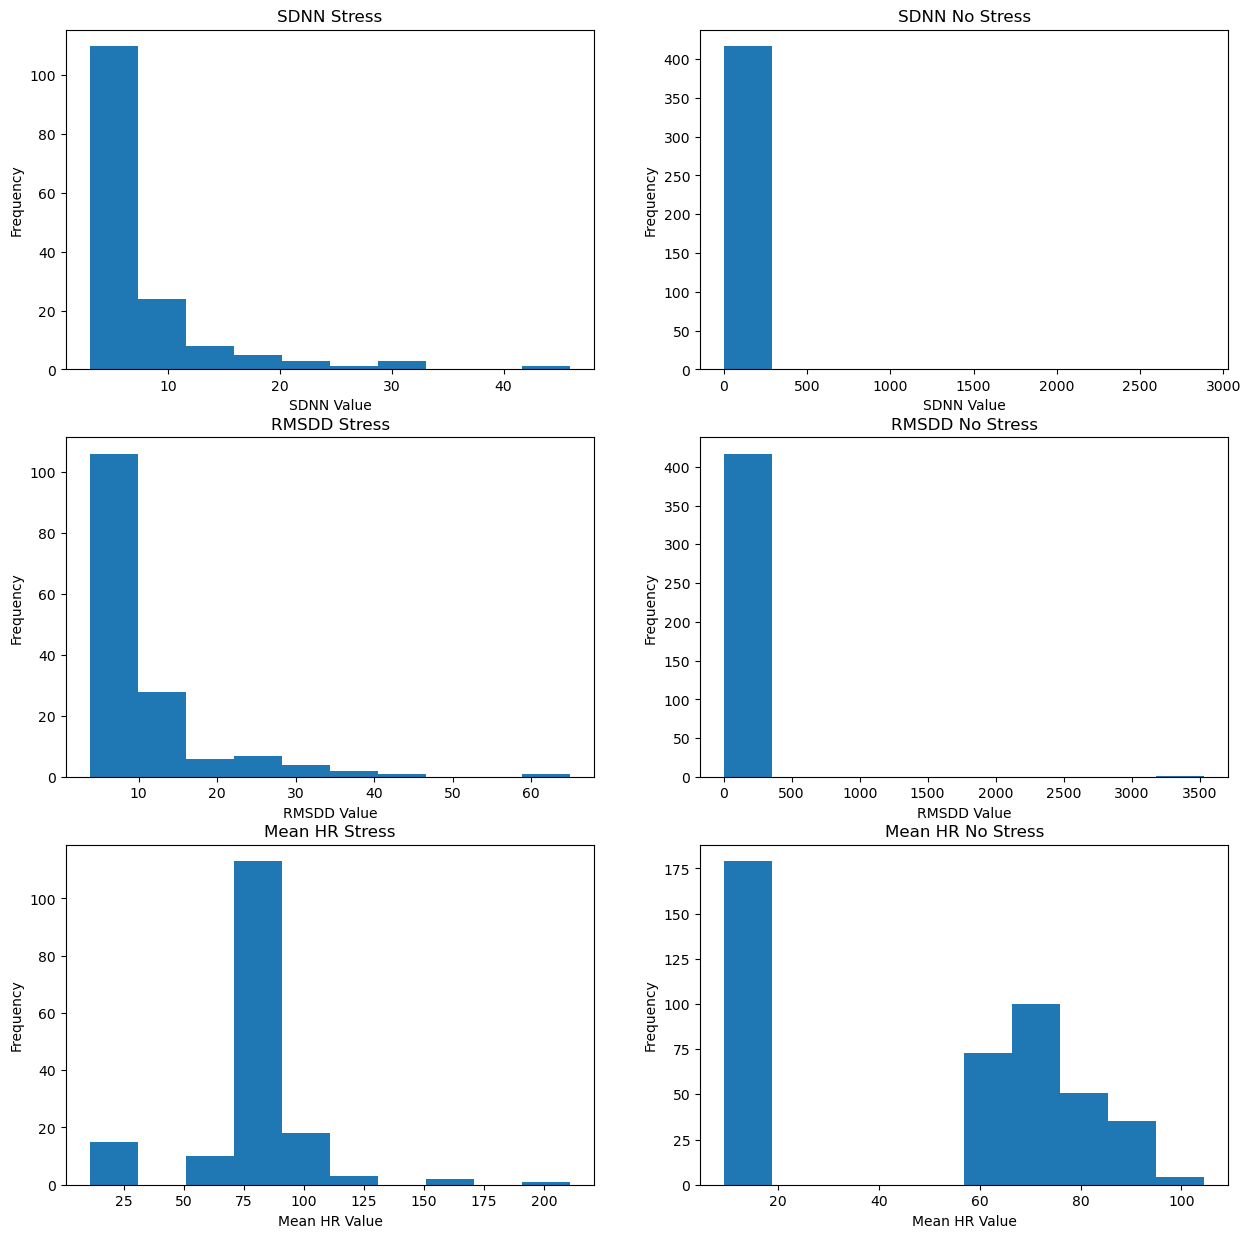

In [57]:
fig, ax = plt.subplots(3,2, figsize=(15,15))

# SDNN
ax[0,0].hist(sdnn_stress)
ax[0,0].set_xlabel("SDNN Value")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("SDNN Stress")

ax[0,1].hist(sdnn_ns)
ax[0,1].set_xlabel("SDNN Value")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("SDNN No Stress")

# RMSDD
ax[1,0].hist(rmsdd_stress)
ax[1,0].set_xlabel("RMSDD Value")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("RMSDD Stress")

ax[1,1].hist(rmsdd_ns)
ax[1,1].set_xlabel("RMSDD Value")
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_title("RMSDD No Stress")

# Mean HR
ax[2,0].hist(mean_hr_stress)
ax[2,0].set_xlabel("Mean HR Value")
ax[2,0].set_ylabel("Frequency")
ax[2,0].set_title("Mean HR Stress")

ax[2,1].hist(mean_hr_ns)
ax[2,1].set_xlabel("Mean HR Value")
ax[2,1].set_ylabel("Frequency")
ax[2,1].set_title("Mean HR No Stress")

print("RANGES:")
print("Max Stress SDNN: ", np.max(sdnn_stress))
print("Min Stress SDNN: ", np.min(sdnn_stress))
print("Mean Stress SDNN: ", np.mean(sdnn_stress), "\n")

print("Max No Stress SDNN: ", np.max(sdnn_ns))
print("Min No Stress SDNN: ", np.min(sdnn_ns))
print("Mean No Stress SDNN: ", np.mean(sdnn_ns), "\n")

print("Max Stress RMSSD: ", np.max(rmsdd_stress))
print("Min Stress RMSSD: ", np.min(rmsdd_stress))
print("Mean Stress RMSSD: ", np.mean(rmsdd_stress), "\n")

print("Max No Stress RMSSD: ", np.max(rmsdd_ns))
print("Min No Stress RMSSD: ", np.min(rmsdd_ns))
print("Mean No Stress RMSSD: ", np.mean(rmsdd_ns), "\n")

print("Max Stress Mean HR: ", np.max(mean_hr_stress))
print("Min Stress Mean HR: ", np.min(mean_hr_stress))
print("Mean Stress Mean HR: ", np.mean(mean_hr_stress), "\n")

print("Max No Stress Mean HR: ", np.max(mean_hr_ns))
print("Min No Stress Mean HR: ", np.min(mean_hr_ns))
print("Mean No Stress Mean HR: ", np.mean(mean_hr_ns), "\n")

#### b) Visualizing HR, BR, GSR, ECG of all data

RANGES:
Max Stress BR:  90.61
Min Stress BR:  0.0
Median Stress BR:  11.092
Mean Stress BR:  11.666438558363543 

Max No Stress BR:  136.61
Min No Stress BR:  0.0
Median No Stress BR:  10.9
Mean No Stress BR:  11.636474931673947 

Max Stress HR:  391.0
Min Stress HR:  0.0
Median Stress HR:  79.9920008
Mean Stress HR:  83.13482690841884 

Max No Stress HR:  391.0
Min No Stress HR:  0.0
Median No Stress HR:  73.0
Mean No Stress HR:  76.01097341700267 

Max Stress GSR:  32.762
Min Stress GSR:  -32.763
Median Stress GSR:  8.869
Mean Stress GSR:  11.360978242982219 

Max No Stress GSR:  32.124
Min No Stress GSR:  -32.389
Median No Stress GSR:  6.139
Mean No Stress GSR:  9.49193749027184 

Max Stress ECG:  9.952
Min Stress ECG:  -10.0
Median Stress ECG:  -0.041
Mean Stress ECG:  -0.08062417307012709 

Max No Stress ECG:  8.282
Min No Stress ECG:  -10.0
Median No Stress ECG:  -0.046
Mean No Stress ECG:  -0.004883536896067198 



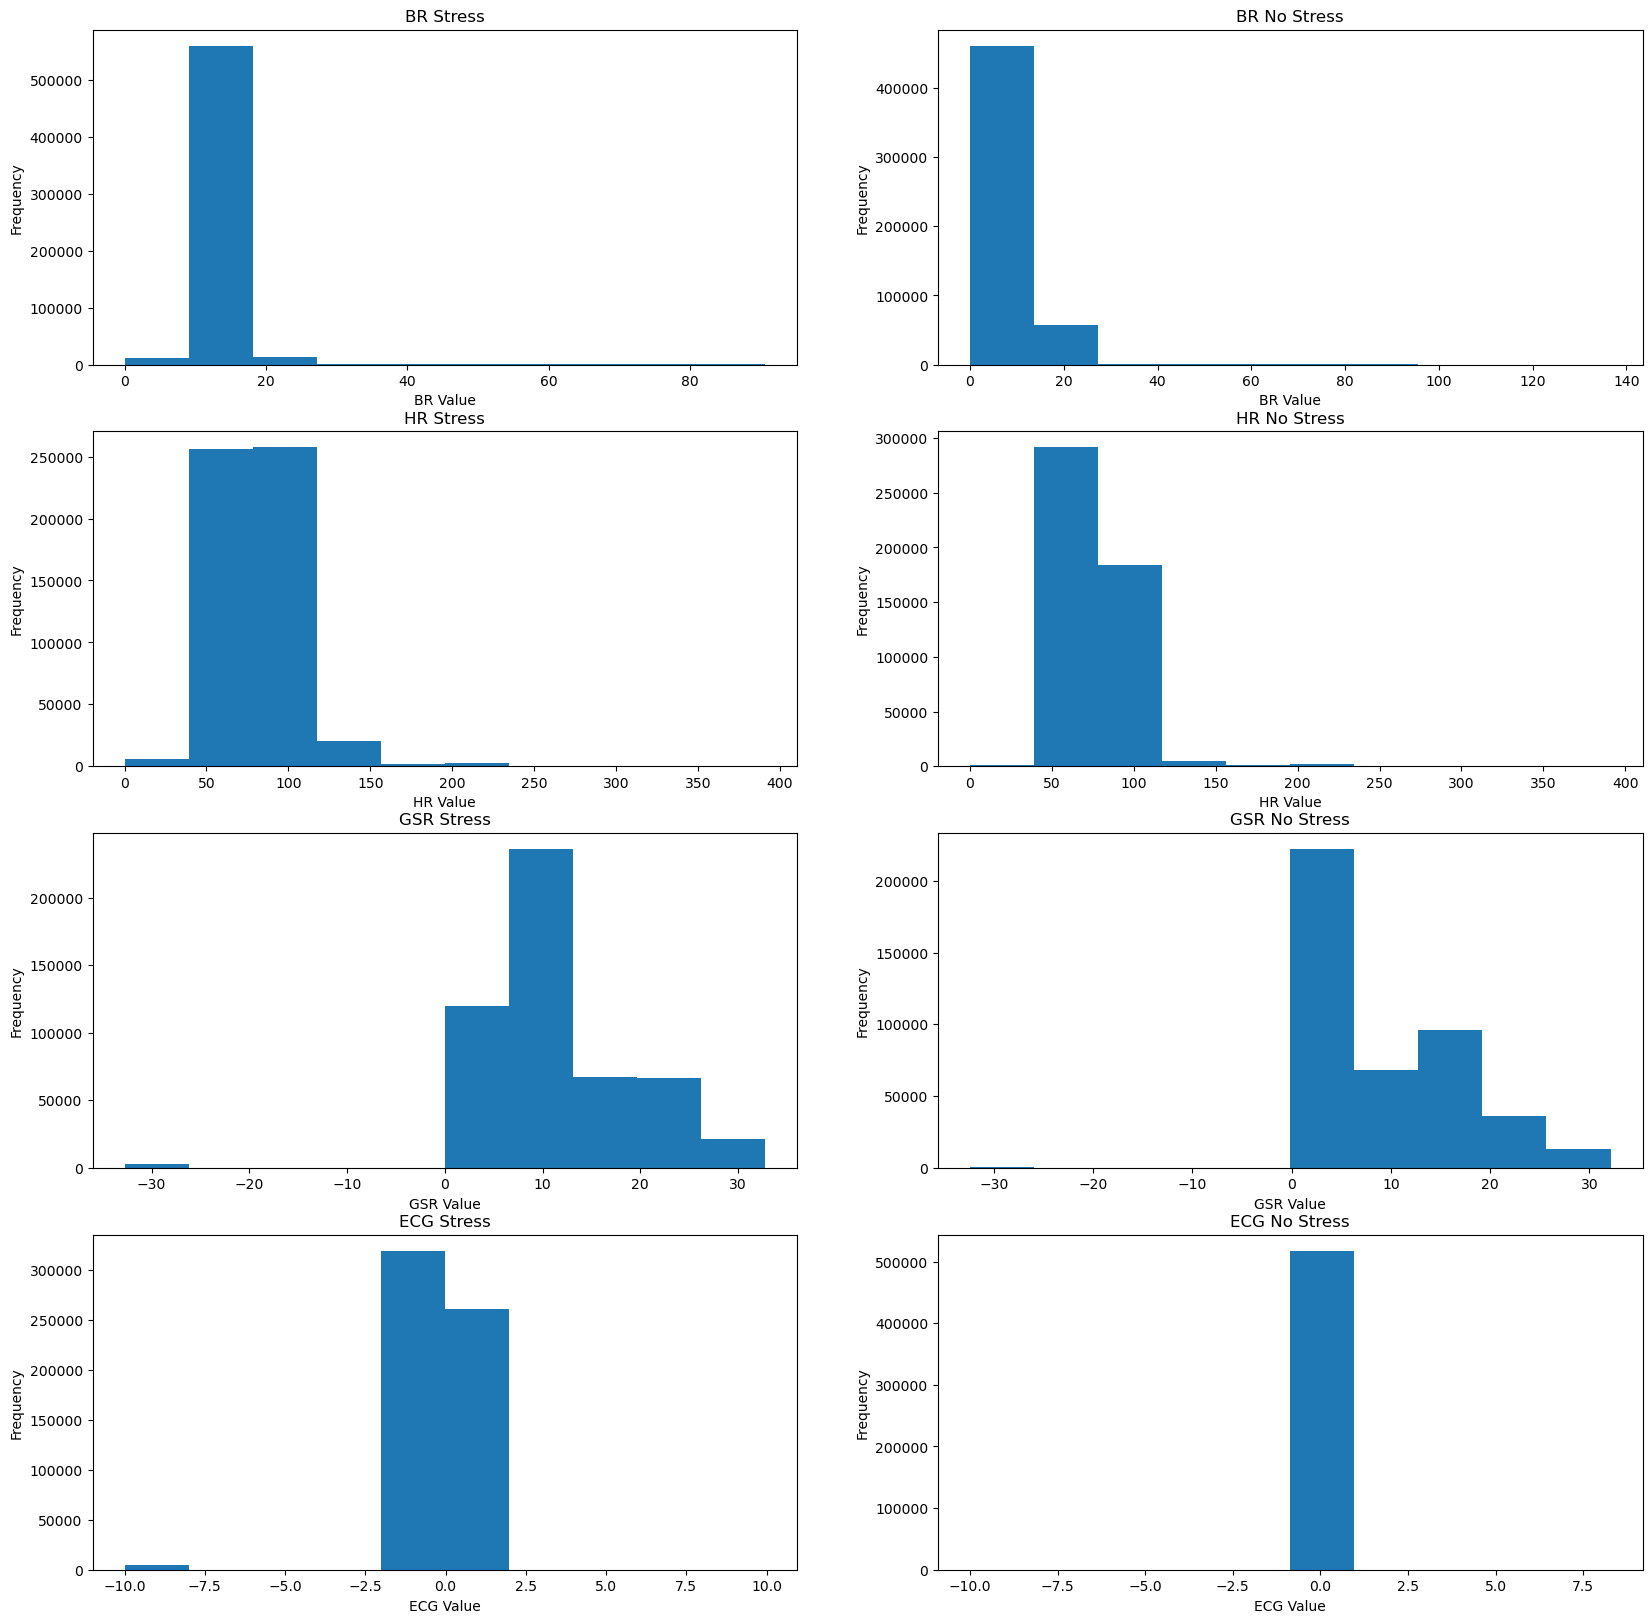

In [58]:
def show_histogram():
    fig, ax = plt.subplots(4,2, figsize=(20,20))
    
    # RESP
    ax[0,0].hist(br_stress)
    ax[0,0].set_xlabel("BR Value")
    ax[0,0].set_ylabel("Frequency")
    ax[0,0].set_title("BR Stress")
    
    ax[0,1].hist(br_ns)
    ax[0,1].set_xlabel("BR Value")
    ax[0,1].set_ylabel("Frequency")
    ax[0,1].set_title("BR No Stress")
    
    # HR
    ax[1,0].hist(hr_stress)
    ax[1,0].set_xlabel("HR Value")
    ax[1,0].set_ylabel("Frequency")
    ax[1,0].set_title("HR Stress")
    
    ax[1,1].hist(hr_ns)
    ax[1,1].set_xlabel("HR Value")
    ax[1,1].set_ylabel("Frequency")
    ax[1,1].set_title("HR No Stress")
    
    # HAND GSR
    ax[2,0].hist(hand_gsr_stress)
    ax[2,0].set_xlabel("GSR Value")
    ax[2,0].set_ylabel("Frequency")
    ax[2,0].set_title("GSR Stress")
    
    ax[2,1].hist(hand_gsr_ns)
    ax[2,1].set_xlabel("GSR Value")
    ax[2,1].set_ylabel("Frequency")
    ax[2,1].set_title("GSR No Stress")
    
    # ECG
    ax[3,0].hist(ecg_stress)
    ax[3,0].set_xlabel("ECG Value")
    ax[3,0].set_ylabel("Frequency")
    ax[3,0].set_title("ECG Stress")
    
    ax[3,1].hist(ecg_ns)
    ax[3,1].set_xlabel("ECG Value")
    ax[3,1].set_ylabel("Frequency")
    ax[3,1].set_title("ECG No Stress")
    
    print("RANGES:")
    print("Max Stress BR: ", np.max(br_stress))
    print("Min Stress BR: ", np.min(br_stress))
    print("Median Stress BR: ", np.median(br_stress))
    print("Mean Stress BR: ", np.mean(br_stress), "\n")
    
    print("Max No Stress BR: ", np.max(br_ns))
    print("Min No Stress BR: ", np.min(br_ns))
    print("Median No Stress BR: ", np.median(br_ns))
    print("Mean No Stress BR: ", np.mean(br_ns), "\n")
    
    print("Max Stress HR: ", np.max(hr_stress))
    print("Min Stress HR: ", np.min(hr_stress))
    print("Median Stress HR: ", np.median(hr_stress))
    print("Mean Stress HR: ", np.mean(hr_stress), "\n")
    
    print("Max No Stress HR: ", np.max(hr_ns))
    print("Min No Stress HR: ", np.min(hr_ns))
    print("Median No Stress HR: ", np.median(hr_ns))
    print("Mean No Stress HR: ", np.mean(hr_ns), "\n")
    
    print("Max Stress GSR: ", np.max(hand_gsr_stress))
    print("Min Stress GSR: ", np.min(hand_gsr_stress))
    print("Median Stress GSR: ", np.median(hand_gsr_stress))
    print("Mean Stress GSR: ", np.mean(hand_gsr_stress), "\n")
    
    print("Max No Stress GSR: ", np.max(hand_gsr_ns))
    print("Min No Stress GSR: ", np.min(hand_gsr_ns))
    print("Median No Stress GSR: ", np.median(hand_gsr_ns))
    print("Mean No Stress GSR: ", np.mean(hand_gsr_ns), "\n")
    
    print("Max Stress ECG: ", np.max(ecg_stress))
    print("Min Stress ECG: ", np.min(ecg_stress))
    print("Median Stress ECG: ", np.median(ecg_stress))
    print("Mean Stress ECG: ", np.mean(ecg_stress), "\n")
    
    print("Max No Stress ECG: ", np.max(ecg_ns))
    print("Min No Stress ECG: ", np.min(ecg_ns))
    print("Median No Stress ECG: ", np.median(ecg_ns))
    print("Mean No Stress ECG: ", np.mean(ecg_ns), "\n")


show_histogram()

#### c) Removing Outliers

In [59]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]


br_stress = reject_outliers(np.array(br_stress))
br_ns = reject_outliers(np.array(br_ns))

hr_stress = reject_outliers(np.array(hr_stress))
hr_ns = reject_outliers(np.array(hr_ns))

hand_gsr_stress = reject_outliers(np.array(hand_gsr_stress))
hand_gsr_ns = reject_outliers(np.array(hand_gsr_ns))

ecg_stress = reject_outliers(np.array(ecg_stress))
ecg_ns = reject_outliers(np.array(ecg_ns))

#### d) Visualizing HR, BR, GSR, ECG of all data with outliers removed

RANGES:
Max Stress BR:  12.834
Min Stress BR:  9.35
Median Stress BR:  10.91
Mean Stress BR:  11.033512865950613 

Max No Stress BR:  12.162
Min No Stress BR:  9.638
Median No Stress BR:  10.81
Mean No Stress BR:  10.853255401971607 

Max Stress HR:  101.0
Min Stress HR:  58.0
Median Stress HR:  76.0
Mean Stress HR:  77.89659474218354 

Max No Stress HR:  91.0
Min No Stress HR:  53.994600539946006
Median No Stress HR:  71.0
Mean No Stress HR:  72.26215494453363 

Max Stress GSR:  14.646
Min Stress GSR:  3.235
Median Stress GSR:  7.579
Mean Stress GSR:  8.136511824291007 

Max No Stress GSR:  12.709
Min No Stress GSR:  -0.263
Median No Stress GSR:  4.42
Mean No Stress GSR:  4.9896469425285765 

Max Stress ECG:  0.107
Min Stress ECG:  -0.189
Median Stress ECG:  -0.06
Mean Stress ECG:  -0.050563457115902294 

Max No Stress ECG:  0.081
Min No Stress ECG:  -0.173
Median No Stress ECG:  -0.065
Mean No Stress ECG:  -0.057261158539627675 



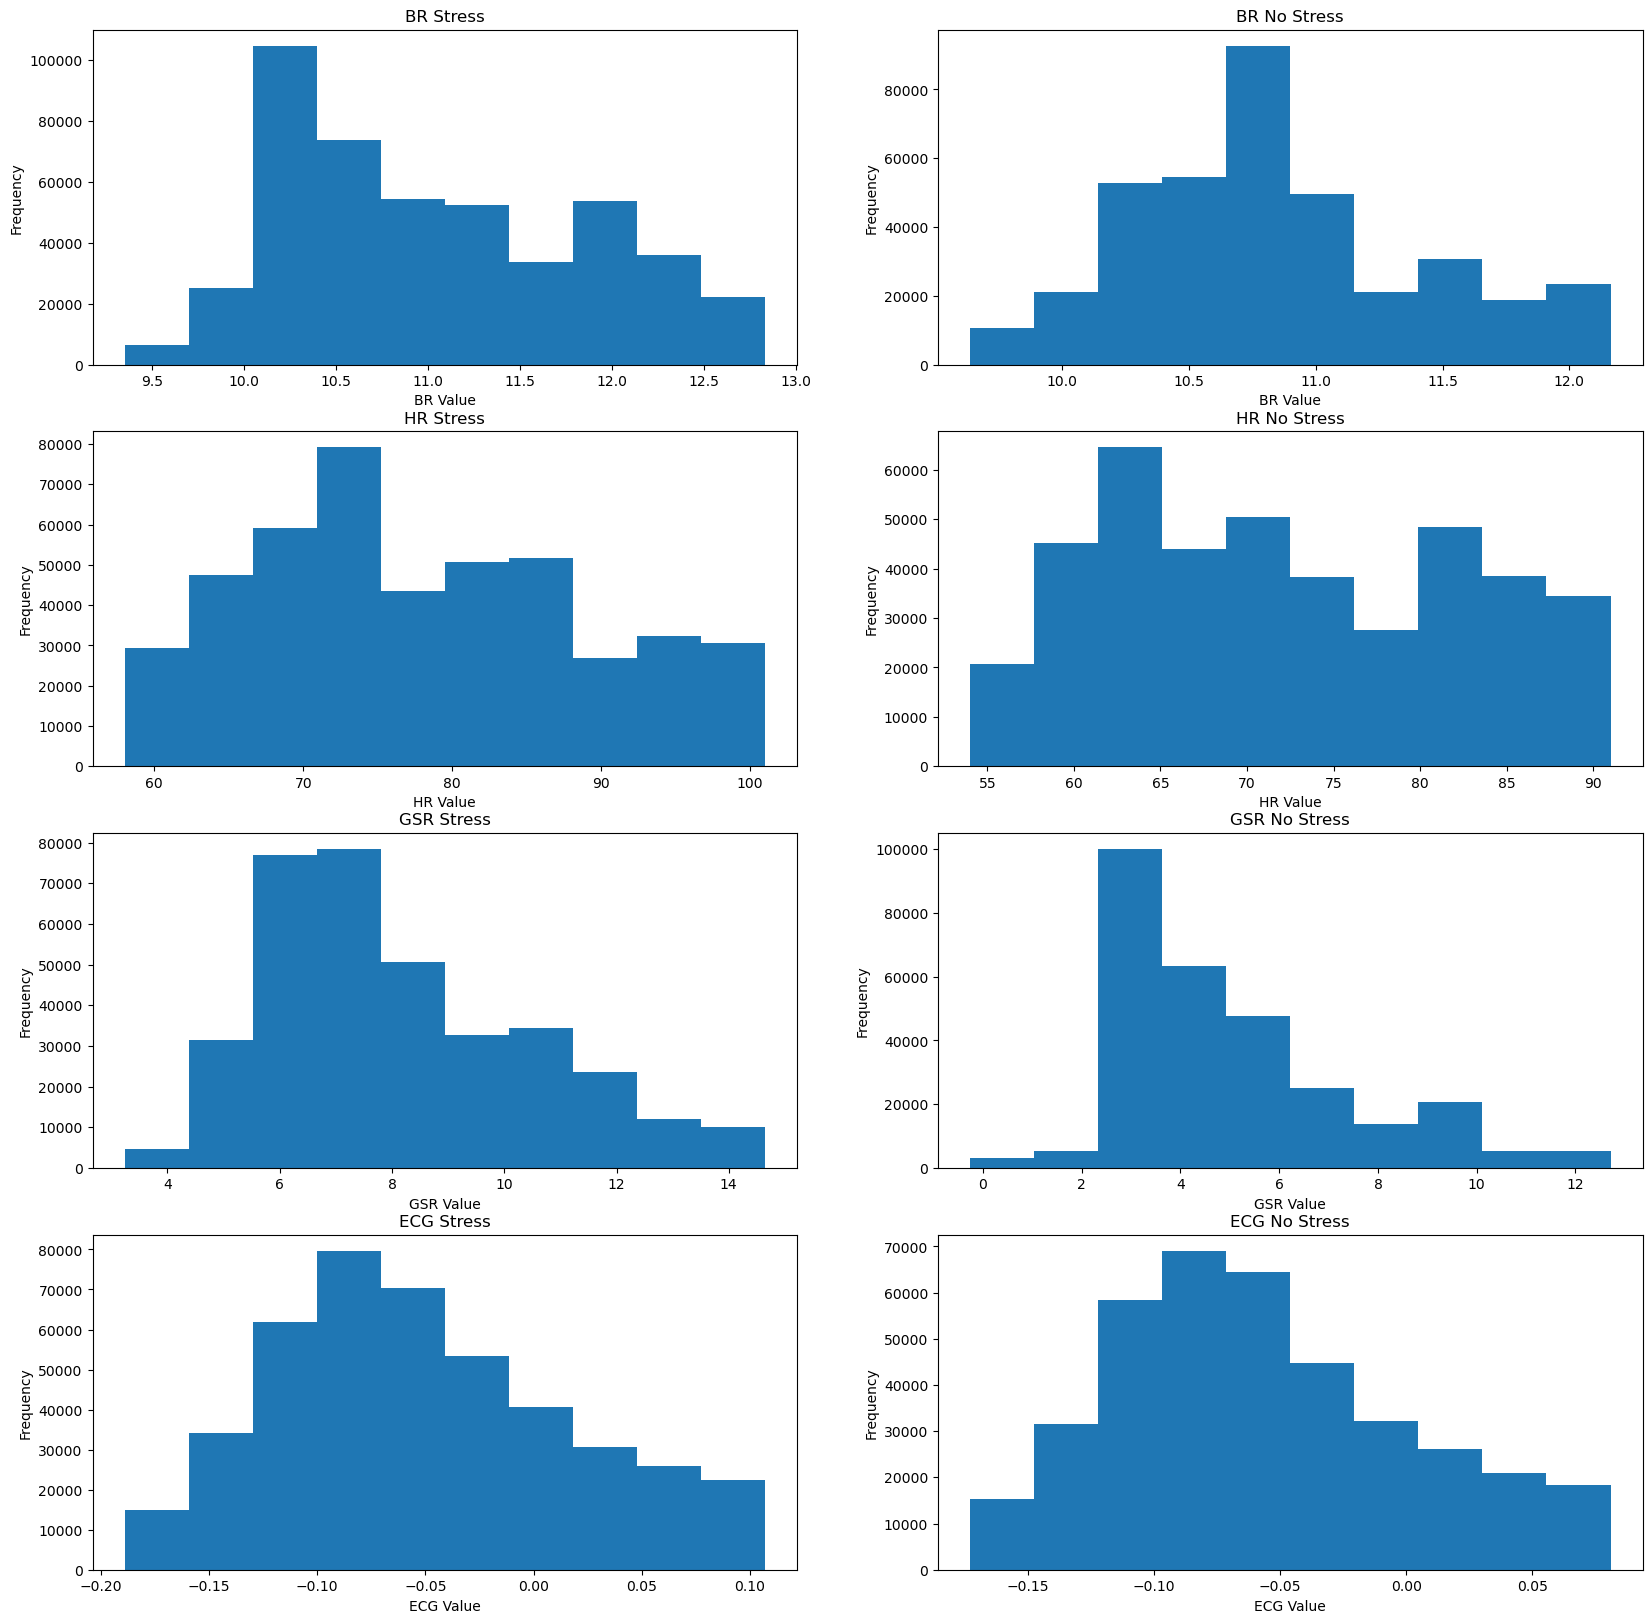

In [60]:
show_histogram()

### 1.3.4: Data Splits

Using an 80/20 split because we don't have many data points.

In [61]:
X, y = data[:,:3], data[:,-1]
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

# 2: ML Model I

Machine learning model using only HRV features.

## 2.1: MLP Classifier

Based on the research paper being followed, the optimal parameters included:
- Learning rate = 0.001
- Momentum = 0.1
- Three hidden layers
     - Layer 1 = 100 nodes
     - Layer 2 = 10  nodes
     - Layer 3 = 400 nodes

In [71]:
# Create and train classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes = (100,10,400), activation='relu', solver='adam', learning_rate='constant', learning_rate_init=0.001, momentum=0.1, batch_size=30, max_iter=300)
mlp_classifier.fit(X_tr, y_tr)

# Compute the training and test error rates
y_tr_pred = mlp_classifier.predict(X_tr)
tr_accuracy = accuracy_score(y_tr, y_tr_pred)
tr_error = 1 - (tr_accuracy)

y_val_pred = mlp_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - (val_accuracy)

print("Training Error: ", tr_error)
print("Validation Error: ", val_error)

print("Training Accuracy: ", tr_accuracy)
print("Validation Accuracy: ", val_accuracy)

# # Cross Validation
# scores = cross_val_score(mlp_classifier, X, y, cv=3)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Confidence Score
conf = mlp_classifier.predict_proba(X_val)
print(conf)
print(mlp_classifier.classes_)

C:\Users\citla\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training Error:  0.18734581516796756
Validation Error:  0.18874174089557727
Training Accuracy:  0.8126541848320324
Validation Accuracy:  0.8112582591044227
[[9.99986081e-01 1.39187681e-05]
 [2.63087814e-01 7.36912186e-01]
 [9.99961120e-01 3.88800781e-05]
 ...
 [9.95817967e-01 4.18203250e-03]
 [2.26672943e-01 7.73327057e-01]
 [3.35503162e-01 6.64496838e-01]]
[0. 1.]


In [65]:
# AVNN (1), SDNN(4), RMSSD(1), HR(1), NNRR(1), PNN50, TP, VLF 
# "HRV features were extracted from the RR intervals by splitting the dataset in windows of 30s"
# Extract time domain features with pyhrv
hr_vals = values[:,4]

# hrv features
avnn = []
sdnn = []
rmssd = []
mean_hr = []  # take 30s slice from OG data, compute mean of that, and store val here
mean_hr_sanity_check = []
nnrr = []

rr_window = []
counter = 30

for i in range(len(qrs_inds)):
    if (i+1) < len(qrs_inds) and qrs_inds[i+1] < counter:
        if i < len(r_to_r):
            rr_window.append(r_to_r[i])
    else:
        # this block handles missing values by using the next value to estimate
        if i < len(r_to_r):
            rr_window.append(r_to_r[i+1])

        # Calculate and store HRV features
        sdnn_val = (pyhrv.time_domain.sdnn(rr_window))['sdnn']
        rmssd_val = (pyhrv.time_domain.rmssd(rr_window))['rmssd']

        sdnn.append(sdnn_val)
        rmssd.append(rmssd_val)
        
        # take slice of HR and store mean
        hr_slice = hr_vals[counter-30:counter]
        mean_hr.append(np.mean(hr_slice))

        # DELETE
        # computing again using rr intervals just as a sanity check
        mean_hr_sanity = proc.calc_mean_hr(rr_window, fs=15.5)
        mean_hr_sanity_check.append(mean_hr_sanity)
        # END DELETE
        
        # clear current rr_window
        rr_window.clear()
        
        # append current index to rr_window
        if i < len(r_to_r):
            rr_window.append(r_to_r[i])
        
        # increment counter by 30s
        counter += 30
        

# # Visualizations (Printing)
# print("MEAN HR: ", mean_hr)
# print("MEAN HR SANITY: ", mean_hr_sanity_check)
# print("SDNN: ", sdnn)
# print("RMSSD: ", rmssd)

print(len(sdnn))
print(len(rmssd))
print(len(mean_hr))
print(len(mean_hr_sanity_check))

NameError: name 'r_to_r' is not defined

# 3: ML Model II

This model will not use ECG features.

## 3.1: Data Splits

### a) Shuffle and trim the data

In [66]:
print("---BREATHING RATE---")
print("Size of BR Stress: ", np.size(br_stress))
print("Size of BR No Stress: ", np.size(br_ns), "\n")

print("---HEART RATE---")
print("Size of HR Stress: ", np.size(hr_stress))
print("Size of HR No Stress: ", np.size(hr_ns), "\n")

print("---GSR---")
print("Size of GSR Stress: ", np.size(hand_gsr_stress))
print("Size of GSR No Stress: ", np.size(hand_gsr_ns), "\n")

# Lowest size is 289831, so we will shuffle the arrays and trim them to this size
# Shuffle
np.random.shuffle(br_stress)
np.random.shuffle(br_ns)
np.random.shuffle(hr_stress)
np.random.shuffle(hr_ns)
np.random.shuffle(hand_gsr_stress)
np.random.shuffle(hand_gsr_ns)

# Trim
br_stress_trim = br_stress[:289831]
br_ns_trim = br_ns[:289831]
hr_stress_trim = hr_stress[:289831]
hr_ns_trim = hr_ns[:289831]
hand_gsr_stress_trim = hand_gsr_stress[:289831]
hand_gsr_ns_trim = hand_gsr_ns[:289831]

---BREATHING RATE---
Size of BR Stress:  461606
Size of BR No Stress:  375835 

---HEART RATE---
Size of HR Stress:  451112
Size of HR No Stress:  412060 

---GSR---
Size of GSR Stress:  354905
Size of GSR No Stress:  289831 



### b) Split the data

In [72]:
# combine stress/no stress points into single array
combined_br = list(br_stress_trim) + list(br_ns_trim)
combined_hr = list(hr_stress_trim) + list(hr_ns_trim)
combined_gsr = list(hand_gsr_stress_trim) + list(hand_gsr_ns_trim)

print("Total Points: ", len(combined_gsr))

# Create Y (label) array
zeros = list(np.zeros((289831,), dtype=int))    # zeros = no stress
ones = list(np.ones((289831,), dtype=int))      # ones  = stress
labels = ones + zeros

# Create a single matrix with feature points and labels
# Organized in the following way:
#    |BR|HR|GSR|Class|
feature_names = ['BR', 'HR', 'GSR']
data = np.column_stack((combined_br, combined_hr, combined_gsr, labels))
print(data)

# Split into X and Y
X = data[:,:3]
y = data[:,3]

# Split into Training and Testing sets (using 70/30 split)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

Total Points:  579662
[[11.38      63.         6.81       1.       ]
 [11.23      68.         7.462      1.       ]
 [11.472     87.         6.627      1.       ]
 ...
 [10.84      76.         4.544      0.       ]
 [10.51      60.         5.398      0.       ]
 [10.9       69.9930007  4.867      0.       ]]


## 3.2) Logistic Regression

### 3.2.1) Initial Training

In [74]:
# Initialize the model
lr = LogisticRegression()

# Fit the model to the training set
lr.fit(X_tr, y_tr)

# Compute the training and test errors
y_tr_pred = lr.predict(X_tr)
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))

y_val_pred = lr.predict(X_val)
val_error = 1 - (accuracy_score(y_val, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

Training Error:  0.23116203300941685
Testing Error:  0.2309674006175999


### 3.2.2) Varying Regularization

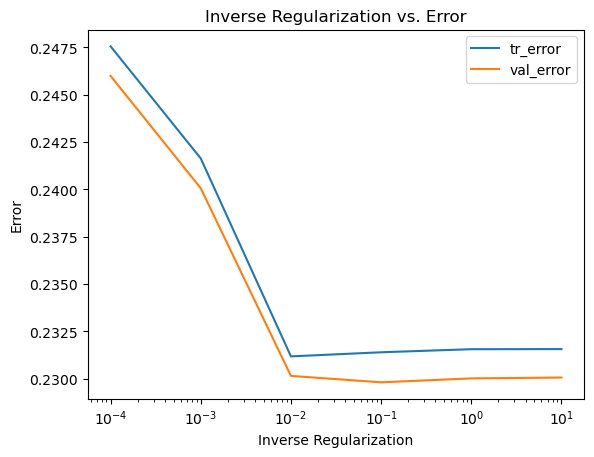

In [69]:
C_vals = [.0001,.001,.01,.1,1.,10.]
training_error = []
val_error = []

for c in C_vals:
    # Train a logistic regression model with each inverse regularization C
    lr_reg = LogisticRegression(C=c, solver='liblinear')
    lr_reg.fit(X_tr, y_tr)
    
    # Compute the training and test error rates
    y_tr_pred = lr_reg.predict(X_tr)
    y_tr_error = 1 - (accuracy_score(y_tr, y_tr_pred))
    training_error.append(y_tr_error)

    y_val_pred = lr_reg.predict(X_val)
    y_val_error = 1 - (accuracy_score(y_val, y_val_pred))
    val_error.append(y_val_error)
    
# Plot the resulting performance as a function of C
plt.semilogx(C_vals, training_error, label='tr_error')
plt.semilogx(C_vals, val_error, label='val_error')

plt.title("Inverse Regularization vs. Error")
plt.xlabel('Inverse Regularization')
plt.ylabel('Error')
plt.legend()

plt.show()

### 3.2.3) Sandbox for Varying Other Parameters

In [70]:
# Initialize the model
lr = LogisticRegression(C=1, solver='liblinear')

# Fit the model to the training set
lr.fit(X_tr, y_tr)

# Compute the training and test errors
y_tr_pred = lr.predict(X_tr)
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))

y_val_pred = lr.predict(X_val)
val_error = 1 - (accuracy_score(y_val, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

Training Error:  0.2315612808462083
Testing Error:  0.23001857399985048


### 3.2.4) Cross Validation

In [71]:
# Cross Validation
scores = cross_val_score(lr, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.77 accuracy with a standard deviation of 0.00


### 3.3.5) Feature Importance

[[0.35199679 0.04935468 0.53509143]]
Feature: BR, Score: 0.35200
Feature: HR, Score: 0.04935
Feature: GSR, Score: 0.53509


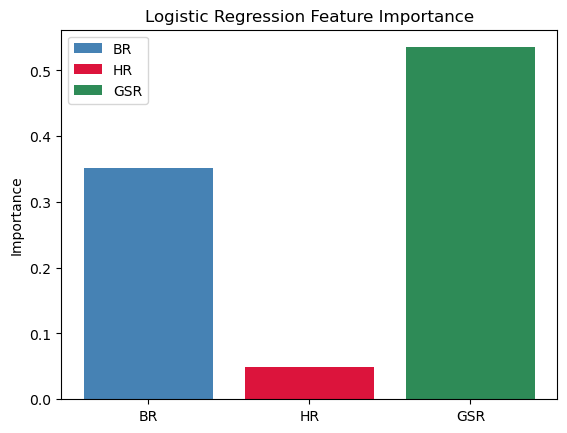

In [128]:
# Get Importance
importance = lr.coef_[0]
print(lr.coef_)

# Summarize feature importance
for i,v in enumerate(importance):
    print("Feature: %s, Score: %.5f" % (feature_names[i],v))
    
# Plot feature importance
bar_labels = ['BR', 'HR', 'GSR']
bar_colors = ['steelblue', 'crimson', 'seagreen']
plt.bar(feature_names, importance, label=bar_labels, color=bar_colors)
plt.ylabel('Importance')
plt.title('Logistic Regression Feature Importance')
plt.legend()
plt.show()

### 3.3.6) Confidence Scores

In [70]:
# Confidence Score
conf = lr.predict_proba(X_val)
print(conf)
print(lr.classes_)

[[0.90208573 0.09791427]
 [0.28221753 0.71778247]
 [0.87285753 0.12714247]
 ...
 [0.79397346 0.20602654]
 [0.04802705 0.95197295]
 [0.45195178 0.54804822]]
[0. 1.]


### 3.3.7) Confusion Matrix

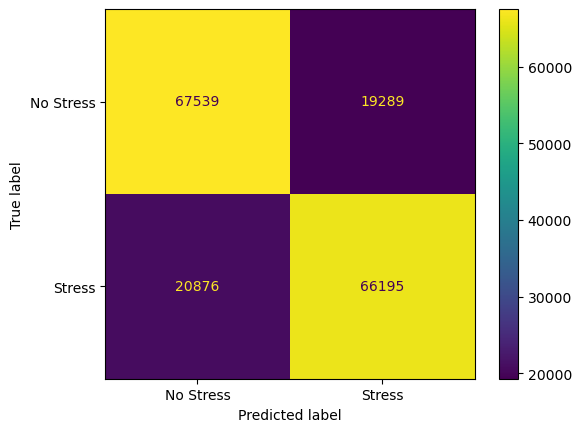

In [89]:
ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val, display_labels=['No Stress', 'Stress'])

## 3.3) Naive Bayes

### a) Initial Training

In [85]:
# Initialize the model
nb = GaussianNB()

# Fit the model to the training set
nb.fit(X_tr, y_tr)

# Compute the training and test errors
y_tr_pred = nb.predict(X_tr)
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))

y_val_pred = lr.predict(X_val)
val_error = 1 - (accuracy_score(y_val, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

Training Error:  0.23202460549631188
Testing Error:  0.2309674006175999


### 3.3.1) Varying Smoothing

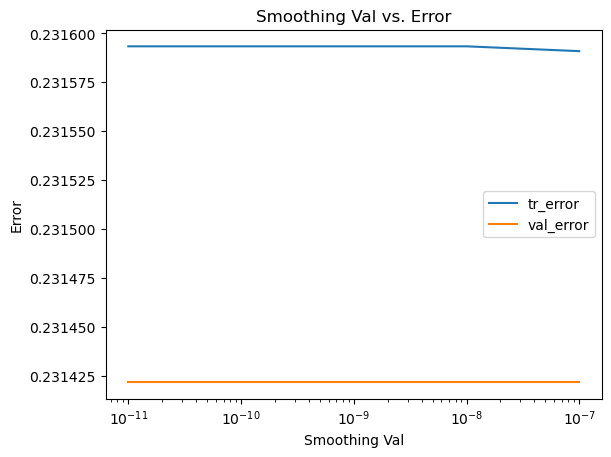

[0.2315908547600447, 0.2315933192528643, 0.2315933192528643, 0.2315933192528643, 0.2315933192528643]
[0.23142168730124957, 0.23142168730124957, 0.23142168730124957, 0.23142168730124957, 0.23142168730124957]


In [73]:
smoothing_vals = [1*(10**-7), 1*(10**-8), 1*(10**-9),1*(10**-10), 1*(10**-11)]
training_error = []
val_error = []

for s in smoothing_vals:
    # Train a logistic regression model with each inverse regularization C
    nb_smooth = GaussianNB(var_smoothing=s)
    nb_smooth.fit(X_tr, y_tr)
    
    # Compute the training and test error rates
    y_tr_pred = nb_smooth.predict(X_tr)
    y_tr_error = 1 - (accuracy_score(y_tr, y_tr_pred))
    training_error.append(y_tr_error)

    y_val_pred = nb_smooth.predict(X_val)
    y_val_error = 1 - (accuracy_score(y_val, y_val_pred))
    val_error.append(y_val_error)
    
# Plot the resulting performance as a function of C
plt.semilogx(smoothing_vals, training_error, label='tr_error')
plt.semilogx(smoothing_vals, val_error, label='val_error')

plt.title("Smoothing Val vs. Error")
plt.xlabel('Smoothing Val')
plt.ylabel('Error')
plt.legend()

plt.show()
print(training_error)
print(val_error)

Smoothing doesn't do anything to improve our model (likewise, it doesn't make it any worse). Therefore, we can continue working with our initial NB model and compare that one with other models.

### 3.3.2) Cross Validation

In [74]:
# Cross Validation
scores = cross_val_score(nb, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.77 accuracy with a standard deviation of 0.00


### 3.3.3) Feature Importance

Feature: BR, Score: 0.03456
Feature: HR, Score: 0.03157
Feature: GSR, Score: 0.19799


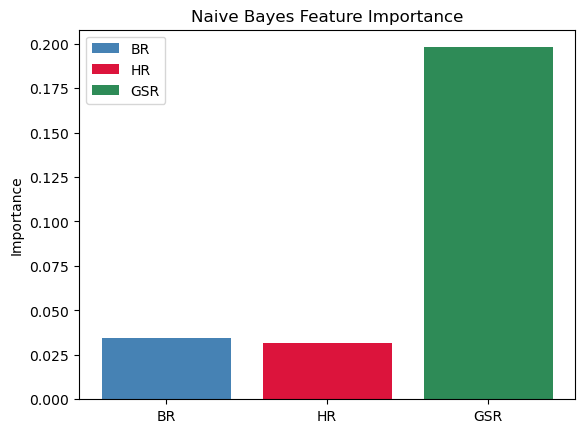

In [133]:
# Perform permutation importance
results = permutation_importance(nb, X_tr, y_tr, scoring='accuracy')

# Get Importance
importance = results.importances_mean

# Summarize feature importance
for i,v in enumerate(importance):
    print("Feature: %s, Score: %.5f" % (feature_names[i],v))
    
# Plot feature importance
bar_labels = ['BR', 'HR', 'GSR']
bar_colors = ['steelblue', 'crimson', 'seagreen']
plt.bar(feature_names, importance, label=bar_labels, color=bar_colors)
plt.ylabel('Importance')
plt.title('Naive Bayes Feature Importance')
plt.legend()
plt.show()

### 3.3.4) Confidence Scores

In [83]:
# Confidence Score
conf = nb.predict_proba(X_val)
print(conf)
print(nb.classes_)

[[0.94071841 0.05928159]
 [0.38138067 0.61861933]
 [0.76827579 0.23172421]
 ...
 [0.86832438 0.13167562]
 [0.03840354 0.96159646]
 [0.54127005 0.45872995]]
[0. 1.]


### 3.3.5) Confusion Matrix

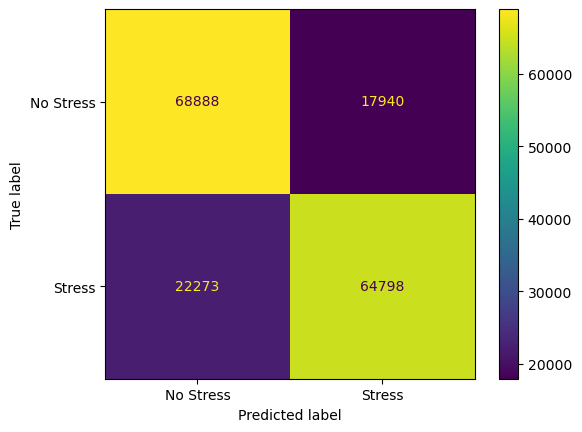

In [106]:
ConfusionMatrixDisplay.from_estimator(nb, X_val, y_val, display_labels=['No Stress', 'Stress'])

## 3.4) K-Nearest Neighbors

### a) Initial Training

In [108]:
# Initialize the model
knc = KNeighborsClassifier(n_neighbors=6)

# Fit the model to the training set
knc.fit(X_tr, y_tr)

# Compute the training and test errors
y_tr_pred = knc.predict(X_tr)
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))

y_val_pred = lr.predict(X_val)
val_error = 1 - (accuracy_score(y_val, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

Training Error:  0.14162454437688998
Testing Error:  0.2309674006175999


### 3.4.1) Varying Number of Neighbors

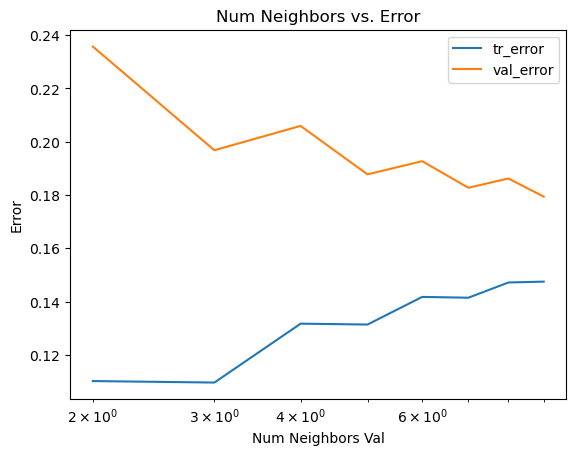

[0.11020965440417185, 0.10965514351973937, 0.1317468571555317, 0.131424008596151, 0.14178720090299013, 0.14148899727180642, 0.14719922713505174, 0.14752700468007185]
[0.23574028602809682, 0.19682689377167206, 0.20596438162381614, 0.18776991242042795, 0.1927268126901247, 0.1827497570428812, 0.18622878797462894, 0.17942023818423336]


In [201]:
num_neighbors = [2, 3, 4, 5, 6, 7, 8, 9]
training_error = []
val_error = []

for n in num_neighbors:
    # Train a logistic regression model with each inverse regularization C
    knc_neighbors = KNeighborsClassifier(n_neighbors=n)
    knc_neighbors.fit(X_tr, y_tr)
    
    # Compute the training and test error rates
    y_tr_pred = knc_neighbors.predict(X_tr)
    y_tr_error = 1 - (accuracy_score(y_tr, y_tr_pred))
    training_error.append(y_tr_error)

    y_val_pred = knc_neighbors.predict(X_val)
    y_val_error = 1 - (accuracy_score(y_val, y_val_pred))
    val_error.append(y_val_error)
    
# Plot the resulting performance as a function of C
plt.semilogx(num_neighbors, training_error, label='tr_error')
plt.semilogx(num_neighbors, val_error, label='val_error')

plt.title("Num Neighbors vs. Error")
plt.xlabel('Num Neighbors Val')
plt.ylabel('Error')
plt.legend()

plt.show()
print(training_error)
print(val_error)

While KNC has greater accuracy than the previous models when more neighbors (n) are used, it runs incredibly slow, which is not desirable for a driving simulation where speedy updates are important.

### 3.4.2) Feature Importance

Feature: BR, Score: 0.10130
Feature: HR, Score: 0.10858
Feature: GSR, Score: 0.24277


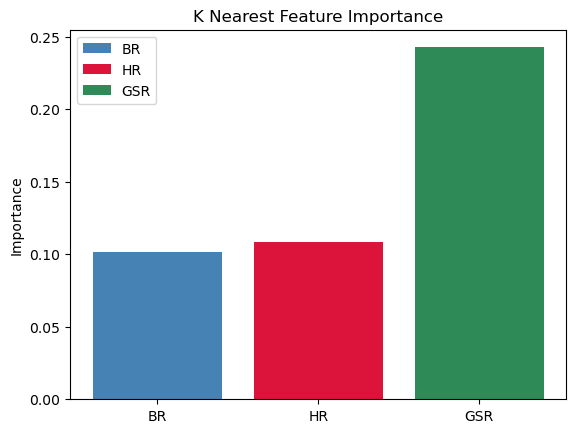

In [135]:
knc = KNeighborsClassifier(n_neighbors=6)
knc.fit(X_tr, y_tr)

# Perform permutation importance
results = permutation_importance(knc, X_tr, y_tr, scoring='accuracy')

# Get Importance
importance = results.importances_mean

# Summarize feature importance
for i,v in enumerate(importance):
    print("Feature: %s, Score: %.5f" % (feature_names[i],v))
    
# Plot feature importance
bar_labels = ['BR', 'HR', 'GSR']
bar_colors = ['steelblue', 'crimson', 'seagreen']
plt.bar(feature_names, importance, label=bar_labels, color=bar_colors)
plt.ylabel('Importance')
plt.title('K Nearest Feature Importance')
plt.legend()
plt.show()

### 3.4.3) Confidence Score

In [109]:
# Confidence Score
conf = nb.predict_proba(X_val)
print(conf)
print(nb.classes_)

[[0.94071841 0.05928159]
 [0.38138067 0.61861933]
 [0.76827579 0.23172421]
 ...
 [0.86832438 0.13167562]
 [0.03840354 0.96159646]
 [0.54127005 0.45872995]]
[0. 1.]


### 3.4.4) Confusion Matrix

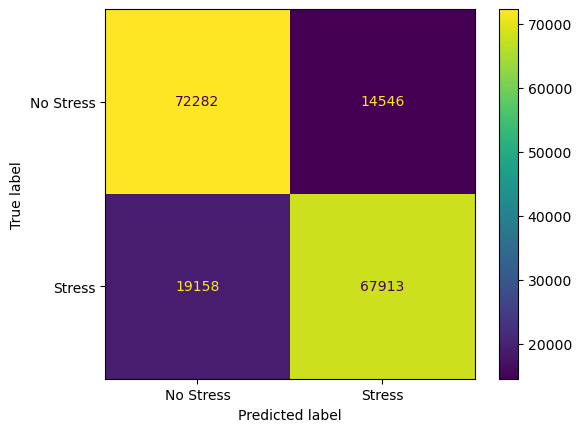

In [110]:
ConfusionMatrixDisplay.from_estimator(knc, X_val, y_val, display_labels=['No Stress', 'Stress'])

## 3.5) Decision Tree

### a) Initial Training

In [100]:
# Initialize the model
dt = DecisionTreeClassifier()

# Fit the model to the training set
dt.fit(X_tr, y_tr)

# Compute the training and test errors
y_tr_pred = dt.predict(X_tr)
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))

y_val_pred = dt.predict(X_val)
val_error = 1 - (accuracy_score(y_val, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

Training Error:  0.0006407681331220827
Testing Error:  0.21187585897561223


### 3.5.1) Varying Max Depth

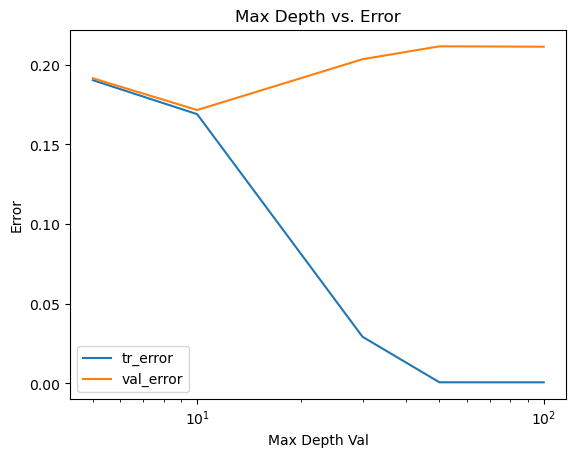

[0.19028102611623043, 0.1689508407617254, 0.029231349334463697, 0.0006580195828599367, 0.0006407681331220827, 0.0006407681331220827]
[0.19148471239052556, 0.17154785248908855, 0.20342267638111777, 0.21153083111461246, 0.21143307322066252, 0.21127781068321272]


In [93]:
max_depth = [5, 10, 30, 50, 70, 100]
training_error = []
val_error = []

for d in max_depth:
    # Train a logistic regression model with each inverse regularization C
    dt_depth = DecisionTreeClassifier(max_depth=d)
    dt_depth.fit(X_tr, y_tr)
    
    # Compute the training and test error rates
    y_tr_pred = dt_depth.predict(X_tr)
    y_tr_error = 1 - (accuracy_score(y_tr, y_tr_pred))
    training_error.append(y_tr_error)

    y_val_pred = dt_depth.predict(X_val)
    y_val_error = 1 - (accuracy_score(y_val, y_val_pred))
    val_error.append(y_val_error)
    
# Plot the resulting performance as a function of C
plt.semilogx(max_depth, training_error, label='tr_error')
plt.semilogx(max_depth, val_error, label='val_error')

plt.title("Max Depth vs. Error")
plt.xlabel('Max Depth Val')
plt.ylabel('Error')
plt.legend()

plt.show()
print(training_error)
print(val_error)

### 3.5.2) Varying Min Samples Split

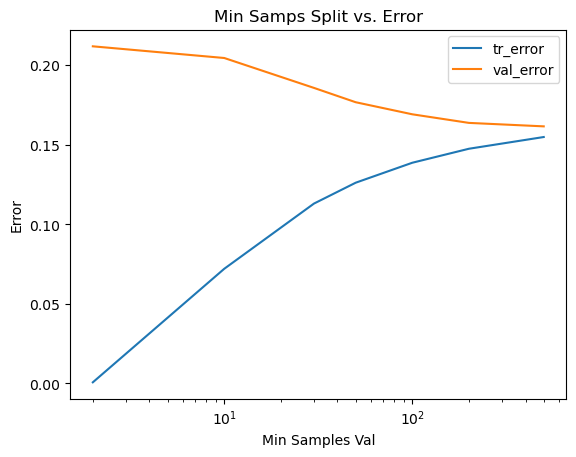

[0.0006407681331220827, 0.07198783526344199, 0.11296249288377702, 0.1260735946845819, 0.13861786313685576, 0.14740870902472625, 0.15478000704844952]
[0.21177235061731237, 0.20443475810671707, 0.18564224061092938, 0.17664276390318523, 0.1690579014255401, 0.16365821540089365, 0.16147878941224503]


In [94]:
min_samps = [2, 10, 30, 50, 100, 200, 500]
training_error = []
val_error = []

for s in min_samps:
    # Train a logistic regression model with each inverse regularization C
    dt_min_samp = DecisionTreeClassifier(min_samples_split=s)
    dt_min_samp.fit(X_tr, y_tr)
    
    # Compute the training and test error rates
    y_tr_pred = dt_min_samp.predict(X_tr)
    y_tr_error = 1 - (accuracy_score(y_tr, y_tr_pred))
    training_error.append(y_tr_error)

    y_val_pred = dt_min_samp.predict(X_val)
    y_val_error = 1 - (accuracy_score(y_val, y_val_pred))
    val_error.append(y_val_error)
    
# Plot the resulting performance as a function of C
plt.semilogx(min_samps, training_error, label='tr_error')
plt.semilogx(min_samps, val_error, label='val_error')

plt.title("Min Samps Split vs. Error")
plt.xlabel('Min Samples Val')
plt.ylabel('Error')
plt.legend()

plt.show()
print(training_error)
print(val_error)

### 3.5.3) Varying Min Samples Leaf

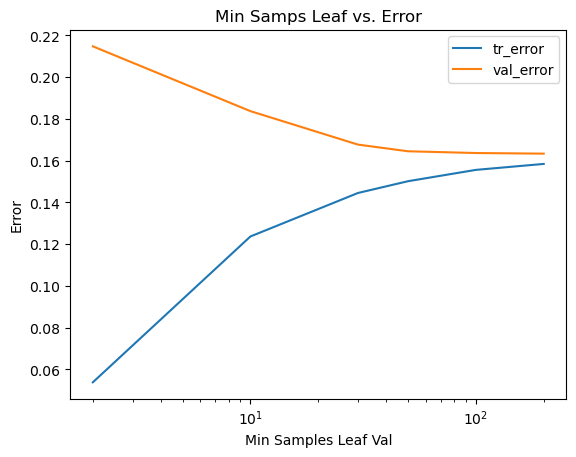

[0.053797413761235036, 0.12366824969255452, 0.14450307199029977, 0.15014183156177374, 0.1555686447507535, 0.158424991928786]
[0.21476259207931037, 0.18371008458933058, 0.16768354044589096, 0.16448628226729312, 0.1636467144721936, 0.16334769032599383]


In [95]:
min_samps_leaf = [2, 10, 30, 50, 100, 200]
training_error = []
val_error = []

for s in min_samps_leaf:
    # Train a logistic regression model with each inverse regularization C
    dt_min_samp_leaf = DecisionTreeClassifier(min_samples_leaf=s)
    dt_min_samp_leaf.fit(X_tr, y_tr)
    
    # Compute the training and test error rates
    y_tr_pred = dt_min_samp_leaf.predict(X_tr)
    y_tr_error = 1 - (accuracy_score(y_tr, y_tr_pred))
    training_error.append(y_tr_error)

    y_val_pred = dt_min_samp_leaf.predict(X_val)
    y_val_error = 1 - (accuracy_score(y_val, y_val_pred))
    val_error.append(y_val_error)
    
# Plot the resulting performance as a function of C
plt.semilogx(min_samps_leaf, training_error, label='tr_error')
plt.semilogx(min_samps_leaf, val_error, label='val_error')

plt.title("Min Samps Leaf vs. Error")
plt.xlabel('Min Samples Leaf Val')
plt.ylabel('Error')
plt.legend()

plt.show()
print(training_error)
print(val_error)

### 3.5.4) Sandbox Training

In [102]:
# Initialize the model
dt = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=200, min_samples_leaf=50)

# Fit the model to the training set
dt.fit(X_tr, y_tr)

# Compute the training and test errors
y_tr_pred = dt.predict(X_tr)
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))

y_val_pred = dt.predict(X_val)
val_error = 1 - (accuracy_score(y_val, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

Training Error:  0.1577127535038927
Testing Error:  0.16361796215044366


### 3.5.5) Cross Validation

In [97]:
# Cross Validation
scores = cross_val_score(dt, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.84 accuracy with a standard deviation of 0.00


### 3.5.6) Feature Importance

Feature: BR, Score: 0.15762
Feature: HR, Score: 0.13866
Feature: GSR, Score: 0.70372


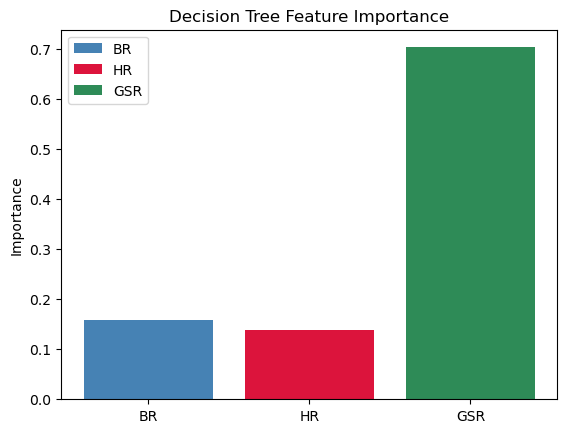

In [129]:
# Get Importance
importance = dt.feature_importances_

# Summarize feature importance
for i,v in enumerate(importance):
    print("Feature: %s, Score: %.5f" % (feature_names[i],v))
    
# Plot feature importance
# bar_labels = ['BR', 'HR', 'GSR']
bar_colors = ['steelblue', 'crimson', 'seagreen']
plt.bar(feature_names, importance, label=feature_names, color=bar_colors)
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.legend()
plt.show()

### 3.5.7) Confidence Score

In [98]:
# Confidence Score
conf = dt.predict_proba(X_val)
print(conf)
print(nb.classes_)

[[1.         0.        ]
 [0.15722433 0.84277567]
 [1.         0.        ]
 ...
 [1.         0.        ]
 [0.09984871 0.90015129]
 [0.45414527 0.54585473]]
[0. 1.]


### 3.5.8) Confusion Matrix

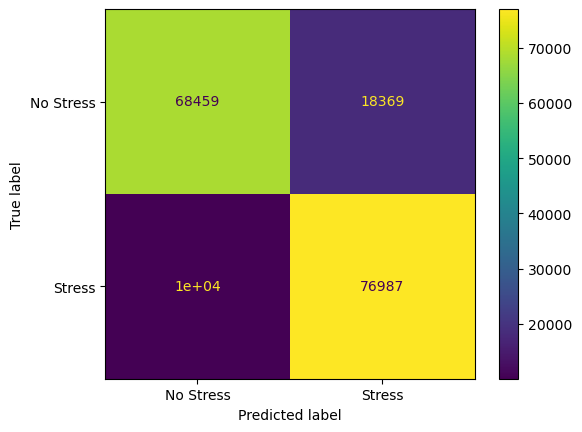

In [103]:
ConfusionMatrixDisplay.from_estimator(dt, X_val, y_val, display_labels=['No Stress', 'Stress'])

Note: I don't know why the confusion matrix for the initial model (with test error ~20%) looks better than the confusion matrix for the optimized model (with test error ~16%).

## 3.6) SVM

you know what, same as with KNN, SVM is going to take a looooooong time (I've been here for about 30 mins...and it's only the initial training...)

## 3.7) Neural Network

In [111]:
# Initialize the model
mlp = MLPClassifier()

# Fit the model to the training set
mlp.fit(X_tr, y_tr)

# Compute the training and test errors
y_tr_pred = mlp.predict(X_tr)
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))
train_error = 1 - (accuracy_score(y_tr, y_tr_pred))

y_val_pred = mlp.predict(X_val)
val_error = 1 - (accuracy_score(y_val, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

C:\Users\citla\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training Error:  0.19902258214770696
Testing Error:  0.19955261387357026


NTS: This was also pretty slow, but accuracy was a bit better than others (still not better than Decision Trees)

### 3.7.1) Sandbox

In [112]:
X_tr_subset, y_tr_subset = X_tr[:2000], y_tr[:2000]
X_val_subset, y_val_subset = X_val[:2000], y_val[:2000]

# Initialize the model
mlp = MLPClassifier(hidden_layer_sizes=(300,100,5,400), activation='tanh', solver='adam', alpha=0.05, batch_size=600, learning_rate='constant', learning_rate_init=0.0002, max_iter=300)

# Fit the model to the training set
mlp.fit(X_tr_subset, y_tr_subset)

# Compute the training and test errors
y_tr_pred = mlp.predict(X_tr_subset)
train_error = 1 - (accuracy_score(y_tr_subset, y_tr_pred))

y_val_pred = mlp.predict(X_val_subset)
val_error = 1 - (accuracy_score(y_val_subset, y_val_pred))

print("Training Error: ", train_error)
print("Testing Error: ", val_error)

Training Error:  0.1925
Testing Error:  0.2005


### 3.7.2) Cross Validation

In [83]:
# Cross Validation
scores = cross_val_score(mlp, X_tr_subset, y_tr_subset, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.80 accuracy with a standard deviation of 0.03


### 3.7.3) Feature Importance

Feature: BR, Score: -0.00052
Feature: HR, Score: 0.02930
Feature: GSR, Score: 0.27243


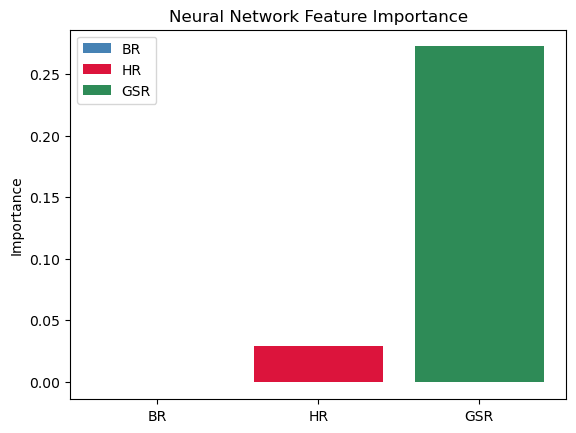

In [134]:
# Perform permutation importance
results = permutation_importance(mlp, X_tr, y_tr, scoring='accuracy')

# Get Importance
importance = results.importances_mean

# Summarize feature importance
for i,v in enumerate(importance):
    print("Feature: %s, Score: %.5f" % (feature_names[i],v))
    
# Plot feature importance
bar_labels = ['BR', 'HR', 'GSR']
bar_colors = ['steelblue', 'crimson', 'seagreen']
plt.bar(feature_names, importance, label=bar_labels, color=bar_colors)
plt.ylabel('Importance')
plt.title('Neural Network Feature Importance')
plt.legend()
plt.show()

### 3.7.4) Confidence Score

In [113]:
# Confidence Score
conf = mlp.predict_proba(X_val)
print(conf)
print(nb.classes_)

[[0.9962894  0.0037106 ]
 [0.209837   0.790163  ]
 [0.99476632 0.00523368]
 ...
 [0.98693988 0.01306012]
 [0.15080409 0.84919591]
 [0.3140237  0.6859763 ]]
[0. 1.]


### 3.7.5) Confusion Matrix

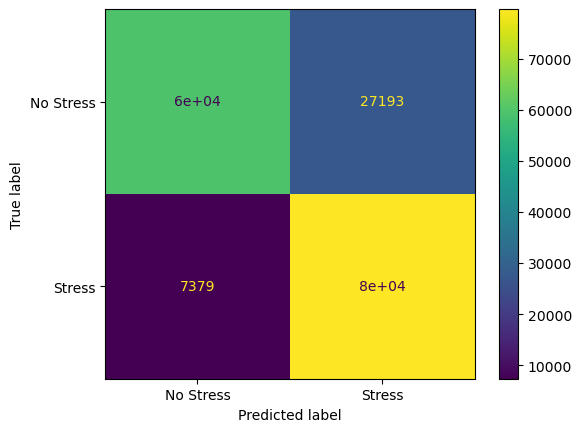

In [114]:
ConfusionMatrixDisplay.from_estimator(mlp, X_val, y_val, display_labels=['No Stress', 'Stress'])

Note: This confusion matrix doesn't look the best, but recall that the model was trained on a subset of the data. May have to try again over the full dataset to get more accurate results of the model's performance.